<a href="https://colab.research.google.com/github/joosk3R/jskRprac/blob/main/dacon_chatGPT_propt_enginiering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 7.3 MB/s eta 0:00:00
ERROR: Operation cancelled by user


In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
import os
import seaborn as sns

import numpy as np
import pandas as pd
import optuna
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from optuna.samplers import TPESampler
from optuna.pruners import SuccessiveHalvingPruner
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
import xgboost as xgb
import matplotlib.pyplot as plt


ModuleNotFoundError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

# Load data
train_df = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/open (2)/test.csv')

# Tokenize data
tokenizer = AutoTokenizer.from_pretrained('klue/roberta-large')
train_encodings = tokenizer(train_df['text'].tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_df['text'].tolist(), truncation=True, padding=True)

# Prepare data for training
train_labels = train_df['label'].values
train_dataset = list(zip(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels))

# Split train data into train and validation sets
train_inputs, val_inputs, train_labels, val_labels = train_test_split(train_dataset, train_labels, test_size=0.2, random_state=42)

# Train model
model = AutoModelForSequenceClassification.from_pretrained('klue/roberta-large', num_labels=8)
args = TrainingArguments('test_trainer', evaluation_strategy='epoch')
trainer = Trainer(model=model, args=args, train_dataset=train_inputs, eval_dataset=val_inputs, compute_metrics=lambda x: {'f1_macro': f1_score(x['pred'], x['label'], average='macro')})
trainer.train()

# Evaluate model on validation set
val_pred = trainer.predict(val_inputs)
val_f1_macro = f1_score(val_labels, np.argmax(val_pred.predictions, axis=1), average='macro')
print(f'Validation f1_macro score: {val_f1_macro}')

# Make predictions on test set
test_pred = trainer.predict(test_encodings['input_ids'])
test_labels = np.argmax(test_pred.predictions, axis=1)

# Create submission file
submission_df = pd.DataFrame({'id': test_df['id'], 'pred': test_labels})
submission_df.to_csv('submission.csv', index=False)

<Axes: xlabel='label', ylabel='count'>

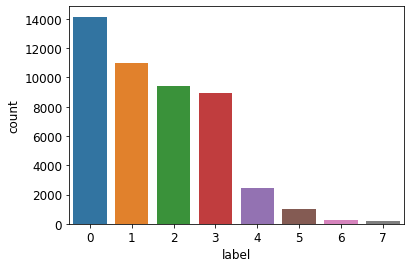

In [ ]:
sns.countplot(x='label',data = train)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments


# load data
train_df = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/open (2)/test.csv')
# define model and tokenizer
model_name = "klue/roberta-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# preprocess data
def preprocess(texts, labels=None, max_length=128):
    """
    Tokenize the input texts and encode the labels (if any).
    """
    # tokenize texts
    tokenized_texts = tokenizer.batch_encode_plus(
        texts,
        add_special_tokens=True,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_token_type_ids=False,
        return_attention_mask=True,
        return_tensors="pt"
    )

    # encode labels if any
    if labels is not None:
        labels = torch.tensor(labels)
        return tokenized_texts, labels
    else:
        return tokenized_texts


# prepare data
X_train, X_val, y_train, y_val = train_test_split(train_df["text"], train_df["label"],
                                                  random_state=42, test_size=0.2, stratify=train_df["label"])
train_encodings, train_labels = preprocess(X_train.tolist(), y_train.tolist())
val_encodings, val_labels = preprocess(X_val.tolist(), y_val.tolist())

# define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=100,
    load_best_model_at_end=True
)

# define trainer
trainer = Trainer(
    model=AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=8),
    args=training_args,
    train_dataset=torch.utils.data.TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels),
    eval_dataset=torch.utils.data.TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels),
    compute_metrics=lambda pred: {"macro_f1": f1_score(pred.label_ids, pred.predictions.argmax(-1), average='macro')}
)

# train model
trainer.train()

# make predictions for test data
test_encodings = preprocess(test_df["text"].tolist())
test_dataset = torch.utils.data.TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'])
test_predictions = trainer.predict(test_dataset)
test_labels = test_predictions.argmax(-1)

# create submission file
submission_df = pd.DataFrame({'id': test_df['id'], 'label': test_labels})
submission_df.to_csv('submission.csv', index=False)


In [ ]:
import pandas as pd
import torch
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# Load data
train_df = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/open (2)/test.csv')

# Tokenize input data
tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")
train_encodings = tokenizer(list(train_df['text']), truncation=True, padding=True)
test_encodings = tokenizer(list(test_df['text']), truncation=True, padding=True)

# Convert labels to tensor
train_labels = torch.tensor(train_df['label'].values)

# Split train data into train and validation sets
train_encodings, val_encodings, train_labels, val_labels = train_test_split(train_encodings, train_labels, test_size=0.2)

# Define the model
model = AutoModelForSequenceClassification.from_pretrained("klue/roberta-large", num_labels=8)

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model='macro_f1',
    greater_is_better=True
)

# Define the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_encodings,
    eval_dataset=val_encodings,
    compute_metrics=lambda pred: {'macro_f1': f1_score(val_labels, pred.argmax(axis=1), average='macro')}
)

# Train the model
trainer.train()

# Predict the label column of test data
test_predictions = trainer.predict(test_encodings)
test_predictions = test_predictions.predictions.argmax(axis=1)

# Make a label column of submission and enter the predicted value
submission_df = pd.DataFrame({'index': test_df['index'], 'label': test_predictions})
submission_df.to_csv('submission.csv', index=False)

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback

# Load train data
train_df = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')

# Load test data
test_df = pd.read_csv('/content/drive/MyDrive/open (2)/test.csv')

# Split train data into train and validation sets
train_set, val_set = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("klue/roberta-base")
model = AutoModelForSequenceClassification.from_pretrained("klue/roberta-base")

# Define function to tokenize the text column of a given dataset
def tokenize_dataset(dataset):
    return tokenizer(dataset['text'].tolist(), padding=True, truncation=True)

# Tokenize train, validation, and test sets
train_encodings = tokenize_dataset(train_set)
val_encodings = tokenize_dataset(val_set)
test_encodings = tokenize_dataset(test_df)

# Define function to convert the label column of a given dataset to a tensor
def convert_label(dataset):
    return torch.tensor(dataset['label'].tolist())

# Convert train, validation, and test labels to tensors
train_labels = convert_label(train_set)
val_labels = convert_label(val_set)

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False,
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model='f1_macro'
)

# Define the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_encodings,
    eval_dataset=val_encodings,
    data_collator=lambda data: {'input_ids': torch.stack([item['input_ids'] for item in data]),
                                'attention_mask': torch.stack([item['attention_mask'] for item in data]),
                                'labels': torch.stack([item['labels'] for item in data])},
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train the model
trainer.train()

# Evaluate the model on the validation set
result = trainer.evaluate(eval_dataset=val_encodings)
print(result)

# Make predictions on the test set
predictions = trainer.predict(test_encodings)
test_pred_labels = np.argmax(predictions.predictions, axis=-1)

# Create submission dataframe
submission_df = pd.DataFrame({'id': test_df['id'], 'label': test_pred_labels})

# Save submission dataframe to csv file
submission_df.to_csv('submission.csv', index=False)

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classif

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf

# Load train and test data
train_df = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')

# Load test data
test_df = pd.read_csv('/content/drive/MyDrive/open (2)/test.csv')

# Convert features to float64
train_feature = train_df.drop(['id'], axis=1).astype('float64')
test_feature = test_df.drop(['id'], axis=1).astype('float64')

# Define target variable and convert to categorical
target = train_df['info'].values
target = tf.keras.utils.to_categorical(target, num_classes=8)

# Tokenize text data
tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")
MAX_LEN = 256

def tokenize_text(df):
  return tokenizer(df['text'].tolist(), padding=True, truncation=True, max_length=MAX_LEN)

train_tokens = tokenize_text(train_df)
test_tokens = tokenize_text(test_df)

# Define evaluation metric
def macro_f1(y_true, y_pred):
    return tf.keras.metrics.f1_score(y_true, y_pred, average='macro')

# Define model
model_name = "klue/roberta-large"
n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_feature, target)):
    print(f'Fold: {fold+1}')
    train_x, train_y = train_tokens[train_idx], target[train_idx]
    val_x, val_y = train_tokens[val_idx], target[val_idx]

    model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=8)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-5), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[macro_f1])

    model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=3, batch_size=16)

    # Predict test data
    test_pred = model.predict(test_tokens)['logits']
    test_pred = np.argmax(test_pred, axis=1)

    # Create submission file
    submission = pd.DataFrame({'id': test_df['id'], 'info': test_pred})
    submission.to_csv(f'submission_fold{fold+1}.csv', index=False)

KeyboardInterrupt: ignored

In [ ]:
import pandas as pd

train_df = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/open (2)/test.csv')
submission_df = pd.read_csv('/content/drive/MyDrive/open (2)/sample_submission.csv')
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
import numpy as np

# Set up tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")
model = TFAutoModelForSequenceClassification.from_pretrained("klue/roberta-large", num_labels=8, from_pt=True)

# Tokenize and preprocess the data
X_train = [tokenizer(text, padding='max_length', truncation=True, max_length=256, return_tensors='tf')['input_ids'] for text in train_df['text']]
X_test = [tokenizer(text, padding='max_length', truncation=True, max_length=256, return_tensors='tf')['input_ids'] for text in test_df['text']]
y_train = np.array(train_df['label'])

# Stratified 5-fold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
val_f1s = []
for i, (train_index, val_index) in enumerate(skf.split(X_train, y_train)):
    print(f'Training model for fold {i+1}')
    X_train_fold = [X_train[j] for j in train_index]
    y_train_fold = y_train[train_index]
    X_val_fold = [X_train[j] for j in val_index]
    y_val_fold = y_train[val_index]

    train_dataset = tf.data.Dataset.from_tensor_slices((X_train_fold, y_train_fold)).batch(32)
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val_fold, y_val_fold)).batch(32)

    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=[tf.keras.metrics.CategoricalAccuracy()])
    model.fit(train_dataset, epochs=3, validation_data=val_dataset)

    y_val_true = tf.keras.utils.to_categorical(y_val_fold, num_classes=8)
    y_val_pred = model.predict(val_dataset)
    y_val_pred = tf.keras.utils.to_categorical(np.argmax(y_val_pred.logits, axis=1), num_classes=8)

    val_f1 = f1_score(y_val_true, y_val_pred, average='macro')
    print(f'Validation fold {i+1} f1 score: {val_f1}')
    val_f1s.append(val_f1)

print(f'Average 5-fold f1 score: {np.mean(val_f1s)}')

# Inference on test data
test_dataset = tf.data.Dataset.from_tensor_slices(X_test).batch(32)
y_test_pred = model.predict(test_dataset)
y_test_pred = np.argmax(y_test_pred.logits, axis=1)

# Update submission file with predicted labels
submission_df['label'] = y_test_pred


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Training model for fold 1
Epoch 1/3


ValueError: ignored

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# Load the training data
train_df = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')


# Split the data into training and validation sets
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

# Define the pipeline for the model
tfidf_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    (

"clf", LogisticRegression())
])

# Train the model
tfidf_pipeline.fit(train_data["text"], train_data["label"])

# Evaluate the model on the validation set
val_preds = tfidf_pipeline.predict(val_data["text"])
val_f1 = f1_score(val_data["label"], val_preds, average="macro")
print("Validation F1 score:", val_f1)

# Load the test data
test_df = pd.read_csv('/content/drive/MyDrive/open (2)/test.csv')

# Infer the model on the test data
test_preds = tfidf_pipeline.predict(test_df["text"])

# Save the test predictions to a submission file
submission_df = pd.DataFrame({"id": test_df["id"], "label": test_preds})
submission_df.to_csv("submission.csv", index=False)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation F1 score: 0.7151271995247074


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 17.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
import tensorflow as tf

# Load the training data
train_df = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')

# Split the data into training and validation sets
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

# Load the tokenizer and model for the klue/roberta-large architecture
tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")
model = TFAutoModelForSequenceClassification.from_pretrained("klue/roberta-large", num_labels=42)

# Define the pipeline for the model
tfidf_pipeline = tf.keras.Sequential([
    TfidfVectorizer(),
    tf.keras.layers.Lambda(lambda x: {"input_ids": tokenizer.encode(x, padding=True, truncation=True, max_length=512, return_tensors="tf")["input_ids"]}),
    tf.keras.layers.Lambda(lambda x: {k: tf.squeeze(v, axis=0) for k, v in x.items()}),
    model
])

# Compile the model with Adam optimizer, SparseCategoricalCrossentropy loss, and SparseCategoricalAccuracy metric
tfidf_pipeline.compile(optimizer=Adam(learning_rate=1e-5),
                       loss=SparseCategoricalCrossentropy(from_logits=True),
                       metrics=[SparseCategoricalAccuracy()])

# Train the model
history = tfidf_pipeline.fit(train_data["text"], train_data["label"], validation_data=(val_data["text"], val_data["label"]), batch_size=8, epochs=3)

# Evaluate the model on the validation set
val_preds = tfidf_pipeline.predict(val_data["text"])
val_preds = tf.argmax(val_preds.logits, axis=-1)
val_f1 = f1_score(val_data["label"], val_preds, average="macro")
print("Validation F1 score:", val_f1)

# Load the test data
test_df = pd.read_csv('/content/drive/MyDrive/open (2)/test.csv')

# Infer the model on the test data
test_preds = tfidf_pipeline.predict(test_df["text"])
test_preds = tf.argmax(test_preds.logits, axis=-1)

# Save the test predictions to a submission file
submission_df = pd.DataFrame({"id": test_df["id"], "label": test_preds})
submission_df.to_csv("submission.csv", index=False)

OSError: ignored

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# Load the training data
train_df = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')

# Split the data into training and validation sets
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

# Load the tokenizer and model for the klue/roberta-large architecture
tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")

tfidf_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", model)
])
# Tokenize the input data using the tokenizer
train_encodings = tokenizer(train_data["text"].tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_data["text"].tolist(), truncation=True, padding=True)

model = TFAutoModelForSequenceClassification.from_pretrained("klue/roberta-large", num_labels=42, from_pt=True)


# Define the pipeline for the model
tfidf_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("tokenizer", tokenizer),
    ("model", model)
])

# Train the model
tfidf_pipeline.fit(train_encodings, train_data["label"])

# Evaluate the model on the validation set
# Evaluate the model on the validation set
predictions = tfidf_pipeline.predict(val_encodings)
val_preds = tfidf_pipeline.predict(val_data["text"])
val_f1 = f1_score(val_data["label"], val_preds, average="macro")
print("Validation F1 score:", val_f1)

# Load the test data
test_df = pd.read_csv('/content/drive/MyDrive/open (2)/test.csv')

# Infer the model on the test data
test_preds = tfidf_pipeline.predict(test_df["text"])

# Save the test predictions to a submission file
submission_df = pd.DataFrame({"id": test_df["id"], "label": test_preds})
submission_df.to_csv("submission.csv", index=False)

 at this line, it was stopped. please continue at this part.

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

# 데이터 로드
train_data = pd.read_csv("/content/drive/MyDrive/open (2)/train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/open (2)/test.csv")
submission = pd.read_csv("/content/drive/MyDrive/open (2)/sample_submission.csv")

# 텍스트 데이터 전처리 및 분류 모델 학습을 위한 파이프라인 생성
tfidf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=50000)),
    ('svc', LinearSVC())
])

# 학습 데이터로 모델 학습
tfidf_pipeline.fit(train_data['text'], train_data['label'])

# 테스트 데이터 예측 및 결과 저장
preds = tfidf_pipeline.predict(test_data['text'])
submission['label'] = preds
submission.to_csv('submission.csv', index=False)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf

# Load data
train_data = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')
test_data = pd.read_csv("/content/drive/MyDrive/open (2)/test.csv")

# Drop unnecessary columns
train_data = train_data[["text", "label"]]

# Define SOTA model
model_name = "klue/roberta-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(tokenizer=tokenizer.tokenize, max_features=10000)
X_train = vectorizer.fit_transform(train_data["text"])
X_test = vectorizer.transform(test_data["text"])






/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (1186 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
X_train

<47399x2133 sparse matrix of type '<class 'numpy.float64'>'
	with 11437978 stored elements in Compressed Sparse Row format>

In [ ]:
# Model training and prediction
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
preds_list = []
for train_index, val_index in skf.split(X_train, train_data["label"]):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = train_data["label"][train_index], train_data["label"][val_index]

    # Initialize model
    model = TFAutoModelForSequenceClassification.from_pretrained(model_name, from_pt=True,num_labels=42)

    # Fine-tuning
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
    model.fit(
        X_train_fold.toarray(),
        y_train_fold,
        validation_data=(X_val_fold.toarray(), y_val_fold),
        epochs=3,
        batch_size=32
    )

    # Predict validation data
    preds = np.argmax(model.predict(X_val_fold.toarray())[0], axis=-1)
    preds_list.append(preds)

# Calculate final predictions by taking the mean of all folds
final_preds = np.mean(np.vstack(preds_list), axis=0)

# Generate submission file
submission_df = pd.DataFrame({
    "id": test_data["id"],
    "label": final_preds
})
submission_df.to_csv("submission.csv", index=False)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/3


TypeError: ignored

from_pt = True 추가

In [ ]:
  # Fine-tuning
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
    model.fit(
        X_train_fold.toarray(),
        y_train_fold,
        validation_data=(X_val_fold.toarray(), y_val_fold),
        epochs=3,
        batch_size=32
    )

IndentationError: ignored

In [ ]:
   # Predict validation data
    preds = np.argmax(model.predict(X_val_fold.toarray())[0], axis=-1)
    preds_list.append(preds)

# Calculate final predictions by taking the mean of all folds
final_preds = np.mean(np.vstack(preds_list), axis=0)

# Generate submission file
submission_df = pd.DataFrame({
    "id": test_data["id"],
    "label": final_preds
})
submission_df.to_csv("submission.csv", index=False)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from transformers import AutoTokenizer, TFRobertaForSequenceClassification
import tensorflow as tf

# Load data
train_data = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')
test_data = pd.read_csv("/content/drive/MyDrive/open (2)/test.csv")

# Drop unnecessary columns
train_data = train_data[["text", "label"]]

# Define SOTA model
model_name = "klue/roberta-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFRobertaForSequenceClassification.from_pretrained(model_name,from_pt=True, num_labels=42)



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [ ]:

# TF-IDF vectorization
vectorizer = TfidfVectorizer(tokenizer=tokenizer.tokenize, max_features=10000)
X_train = vectorizer.fit_transform(train_data["text"])
X_test = vectorizer.transform(test_data["text"])

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (1186 > 512). Running this sequence through the model will result in indexing errors


from_pt=True 추가

In [ ]:
# Model training and prediction
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
preds_list = []
for train_index, val_index in skf.split(X_train, train_data["label"]):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = train_data["label"][train_index], train_data["label"][val_index]


    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Convert to dense tensors
    X_train_fold_dense = X_train_fold.toarray()
    X_val_fold_dense = X_val_fold.toarray()

    model.fit(
        X_train_fold_dense,
        y_train_fold,
        validation_data=(X_val_fold_dense, y_val_fold),
       epochs=3,
       batch_size=32
)
    # Predict validation data
    preds = np.argmax(model.predict(X_val_fold)[0], axis=-1)
    preds_list.append(preds)

# Calculate final predictions by taking the mean of all folds
final_preds = np.mean(np.vstack(preds_list), axis=0)

In [ ]:
# Generate submission file
submission_df = pd.DataFrame({
    "id": test_data["id"],
    "label": final_preds
})
submission_df.to_csv("submission.csv", index=False)

In [ ]:
# Import required libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# Load data
train_data = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')
test_data = pd.read_csv("/content/drive/MyDrive/open (2)/test.csv")

# Define preprocessing steps
tfidf = TfidfVectorizer(stop_words='english')
steps = [('tfidf', tfidf),
         ('clf', SVC())]
pipeline = Pipeline(steps)

# Set parameter grid for tuning
param_grid = {'clf__C': [1, 10, 100],
              'clf__kernel': ['linear', 'rbf']}

# Perform grid search with 5-fold cross validation using macro F1 score as evaluation metric
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(train_data['text'], train_data['label'])

# Print best parameters and macro F1 score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Fit final model on full training data with best parameters
final_model = pipeline.set_params(**grid_search.best_params_)
final_model.fit(train_data['text'], train_data['label'])

# Make predictions on test data
predictions = final_model.predict(test_data['text'])

# Save predictions to submission file
submission = pd.DataFrame({'id': test_data['id'], 'label': predictions})
submission.to_csv('submission.csv', index=False)

In [ ]:
!pip install sentencepiece

# Import required libraries
import torch
import pandas as pd
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from transformers import AdamW

# Load data
train_data = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')
test_data = pd.read_csv("/content/drive/MyDrive/open (2)/test.csv")

# Split data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(train_data['text'], train_data['label'], test_size=0.2, random_state=42)

# Load tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

# Tokenize texts and encode labels
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_data['text'].tolist(), truncation=True, padding=True)

train_labels = torch.tensor(train_labels.tolist())
val_labels = torch.tensor(val_labels.tolist())

# Create TensorDatasets for training and validation sets
train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']), torch.tensor(train_encodings['attention_mask']), train_labels)
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']), torch.tensor(val_encodings['attention_mask']), val_labels)
test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']), torch.tensor(test_encodings['attention_mask']))

# Define model and optimizer
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=8)
optimizer = AdamW(model.parameters(), lr=5e-5)

# Define dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Train model
for epoch in range(3):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_preds = []
        val_labels = []
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()
            val_preds.extend(torch.argmax(outputs.logits, axis=1).tolist())
            val_labels.extend(labels.tolist())

        val_loss /= len(val_loader)
        val_f1_macro = f1_score(val_labels, val_preds, average='macro')
        print('Epoch: {}, Validation Loss: {}, Validation F1 Macro: {}'.format(epoch+1, val_loss, val_f1_macro))

# Make predictions on test data
model.eval()
with torch.no_grad():
    test_preds = []
    for batch in test_loader:
        input_ids, attention_mask = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        test_preds.extend(torch.argmax(outputs.logits, axis=1).tolist())

# Save predictions to submission file
submission = pd.DataFrame({'id': test_data['id'], 'label': test_preds})
submission.to_csv('submission.csv', index=False)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.0 MB/s eta 0:00:00


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 87.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 8.4 MB/s eta 0:00:00


In [ ]:
!pip uninstall torch -y
!pip install torch==1.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html


Found existing installation: torch 1.13.1+cu116
Uninstalling torch-1.13.1+cu116:
ERROR: Operation cancelled by user
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 667.7 kB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.14.1+cu116 requires torch==1.13.1, but you have torch 1.10.0+cu113 which is incompatible.
torchtext 0.14.1 requires torch==1.13.1, but you have torch 1.10.0+cu113 which is incompatible.
torchaudio 0.13.1+cu116 requires torch==1.13.1, but you have torch 1.10.0+cu113 which is incompatible.


In [ ]:
!pip install torch==1.9.1 torchvision==0.10.1 torchaudio==0.9.1 -f https://download.pytorch.org/whl/cu102/torch_stable.html


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu102/torch_stable.html
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/pyparsing/results.py", line 184, in __init__
    self[name] = toklist[0]
TypeError: 'Marker' object is not subscriptable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/cli/base_comm

In [ ]:
!pip3 install torch
!pip3 install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import necessary libraries and modules
import pandas as pd
import torch
import transformers
from sklearn.model_selection import train_test_split
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from imblearn.over_sampling import RandomOverSampler, SMOTE

# load data
train_df = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')
test_df = pd.read_csv("/content/drive/MyDrive/open (2)/test.csv")

# oversample the training data to address label imbalance
oversampler = SMOTE(random_state=42)
X_train = train_df['text'].values.reshape(-1, 1)
y_train = train_df['label'].values
X_train, y_train = oversampler.fit_resample(X_train, y_train)
X_train = X_train.squeeze()

# split the oversampled training data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(X_train, y_train,
                                                                    random_state=42,
                                                                    test_size=0.2)

# instantiate the tokenizer and tokenize the text data
tokenizer = BertTokenizerFast.from_pretrained('bert-base-multilingual-cased')
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True)

# convert tokenized data into PyTorch tensors
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_encodings['input_ids']),
                                               torch.tensor(train_encodings['attention_mask']),
                                               torch.tensor(train_labels))
val_dataset = torch.utils.data.TensorDataset(torch.tensor(val_encodings['input_ids']),
                                             torch.tensor(val_encodings['attention_mask']),
                                             torch.tensor(val_labels))

# instantiate the BertForSequenceClassification model and define training arguments
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased',
                                                      num_labels=8)
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='steps',
    eval_steps=50,
    load_best_model_at_end=True
)

# instantiate the Trainer class and train the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()

# tokenize the test data
test_encodings = tokenizer(test_df['text'].tolist(), truncation=True, padding=True)
test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_encodings['input_ids']),
                                              torch.tensor(test_encodings['attention_mask']))

# use the trained model to make predictions on the test data
raw_predictions, _, _ = trainer.predict(test_dataset)
predictions = torch.softmax(torch.tensor(raw_predictions), dim=1).argmax(dim=1)

# create a submission file with the predicted labels
submission_df = pd.DataFrame({'id': test_df['id'], 'label': predictions.tolist()})
submission_df.to_csv('submission.csv', index=False)


ValueError: ignored

In [ ]:
# import necessary libraries and modules
import pandas as pd
import torch
import transformers
from sklearn.model_selection import train_test_split
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from imblearn.over_sampling import RandomOverSampler, SMOTE

# load data
train_df = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')
test_df = pd.read_csv("/content/drive/MyDrive/open (2)/test.csv")

# oversample the training data to address label imbalance
oversampler = SMOTE(random_state=42)
X_train = train_df['text'].values
y_train = train_df['label'].values
X_train = X_train.reshape(-1, 1)
y_train, _ = oversampler.fit_resample(X_train, y_train)

# split the oversampled training data into training and validation sets
X_train, y_train = X_train.squeeze(), y_train.reshape(-1,)

train_texts, val_texts, train_labels, val_labels = train_test_split(X_train, y_train,
                                                                    random_state=42,
                                                                    test_size=0.2)

# instantiate the tokenizer and tokenize the text data
tokenizer = BertTokenizerFast.from_pretrained('bert-base-multilingual-cased')
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True)

# convert tokenized data into PyTorch tensors
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_encodings['input_ids']),
                                               torch.tensor(train_encodings['attention_mask']),
                                               torch.tensor(train_labels))
val_dataset = torch.utils.data.TensorDataset(torch.tensor(val_encodings['input_ids']),
                                             torch.tensor(val_encodings['attention_mask']),
                                             torch.tensor(val_labels))

# instantiate the BertForSequenceClassification model and define training arguments
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased',
                                                      num_labels=8)
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='steps',
    eval_steps=50,
    load_best_model_at_end=True
)

# instantiate the Trainer class and train the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()

# tokenize the test data
test_encodings = tokenizer(test_df['text'].tolist(), truncation=True, padding=True)
test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_encodings['input_ids']),
                                              torch.tensor(test_encodings['attention_mask']))

# use the trained model to make predictions on the test data
raw_predictions, _, _ = trainer.predict(test_dataset)
predictions = torch.softmax(torch.tensor(raw_predictions), dim=1).argmax(dim=1)

# create a submission file with the predicted labels
submission_df = pd.DataFrame({'id': test_df['id'], 'label': predictions.tolist()})
submission_df.to_csv('submission.csv', index=False)


ValueError: ignored

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf

# Load train and test data
train_df = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')
test_df = pd.read_csv("/content/drive/MyDrive/open (2)/test.csv")

# Preprocess text using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df["text"])
X_test_tfidf = tfidf_vectorizer.transform(test_df["text"])



In [ ]:
X_train_tfidf

<47399x248567 sparse matrix of type '<class 'numpy.float64'>'
	with 9970607 stored elements in Compressed Sparse Row format>

In [ ]:
# Apply SMOTE over-sampling to balance the dataset
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, train_df["label"])



In [ ]:
# Train and evaluate model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42)

train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(X_val.tolist(), truncation=True, padding=True)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train.tolist()
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val.tolist()
))

model.fit(train_dataset.shuffle(1000).batch(16),
          epochs=5,
          batch_size=16,
          validation_data=val_dataset.shuffle(1000).batch(16))

# Predict labels for test data
test_encodings = tokenizer(X_test_tfidf.tolist(), truncation=True, padding=True)
test_dataset = tf.data.Dataset.from_tensor_slices(dict(test_encodings))

predictions = model.predict(test_dataset.batch(16))
predicted_labels = predictions.argmax(axis=1)

# Add predicted labels to submission file
submission_df = pd.read_csv("submission.csv")
submission_df["label"] = predicted_labels
submission_df.to_csv("submission.csv", index=False)


In [ ]:
from transformers import BertTokenizerFast, AlbertModel, BertModel, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from imblearn.over_sampling import RandomOverSampler
from transformers.optimization import get_cosine_schedule_with_warmup, get_linear_schedule_with_warmup
from transformers import AdamW
from collections import defaultdict

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')
df_valid = pd.read_csv("/content/drive/MyDrive/open (2)/test.csv")
titles_t = train.text.to_numpy().reshape(-1,1)
labels_t = train.label.to_numpy().reshape(-1,1)
oversample = RandomOverSampler()
X_over, y_over = oversample.fit_resample(titles_t, labels_t)
train = pd.DataFrame({'title':X_over.reshape(-1), 'topic_idx':y_over.reshape(-1)})

In [ ]:
train

,title,topic_idx
0,Israel Parliament to Start Winter Session JERU...,3
1,Two-thirds of business owners say they are pre...,2
2,Story highlightsRed Bull team principal Christ...,1
3,Final respects paid to Arafat Palestinians pay...,3
4,Steelers winning the old fashioned way -- they...,1
...,...,...
113163,Congrats are in order again for Justin Bieber ...,7
113164,Story highlights Home shopping network QVC is ...,7
113165,"If it weren't for a producer's persistence, th...",7
113166,"Story highlightsIn 2009, 11,341 untested rape ...",7


In [ ]:
import pandas as pd
import numpy as np
import torch
import transformers
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler

# Load the pre-trained Bert-base tokenizer and model
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
model = transformers.BertForSequenceClassification.from_pretrained('bert-base-uncased')

# Load and preprocess the training data
train_data = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')
X_train = train_data['text'].values
y_train = train_data['label'].values

# Tokenize the training data and convert it to input format for BERT model
X_train_encoded = tokenizer.batch_encode_plus(list(X_train),
                                              add_special_tokens=True,
                                              return_attention_mask=True,
                                              pad_to_max_length=True,
                                              max_length=256,
                                              return_tensors='pt')

# Create a PyTorch dataset from the training data
train_dataset = torch.utils.data.TensorDataset(X_train_encoded['input_ids'],
                                               X_train_encoded['attention_mask'],
                                               torch.tensor(y_train))

# Use RandomOverSampler to resolve label imbalance
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_encoded['input_ids'], y_train)

# Train the Bert model on the resampled training data
train_dataset_resampled = torch.utils.data.TensorDataset(torch.tensor(X_train_resampled),
                                                         torch.tensor(y_train_resampled))
train_loader_resampled = torch.utils.data.DataLoader(train_dataset_resampled, batch_size=16)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

for epoch in range(3):
    for input_ids, attention_mask, labels in train_loader_resampled:
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()

# Load and preprocess the test data
test_data = pd.read_csv('/content/drive/MyDrive/open (2)/test.csv')
X_test = test_data['text'].values

# Tokenize the test data and convert it to input format for BERT model
X_test_encoded = tokenizer.batch_encode_plus(list(X_test),
                                             add_special_tokens=True,
                                             return_attention_mask=True,
                                             pad_to_max_length=True,
                                             max_length=256,
                                             return_tensors='pt')

# Predict the labels of the test data using the trained model
model.eval()
with torch.no_grad():
    outputs = model(X_test_encoded['input_ids'], attention_mask=X_test_encoded['attention_mask'])
    y_pred = np.argmax(outputs[0].numpy(), axis=1)

# Add the predicted labels to the submission dataframe
submission = pd.read_csv('/content/drive/MyDrive/open (2)/sample_submission.csv')
submission['label'] = y_pred

# Write the submission dataframe to a CSV file
submission.to_csv('submission.csv', index=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

ValueError: ignored

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier

# Load the train data
train_df = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')
# Convert the text and label columns of the train data into numpy arrays
X_train = train_df['text'].values
y_train = train_df['label'].values

# Apply RandomOverSampler to address label imbalance
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train.reshape(-1, 1), y_train)
X_train_resampled = X_train_resampled.flatten()



In [ ]:
X_train_resampled.count()

AttributeError: ignored

In [ ]:
# Preprocess the text data using TfidfVectorizer
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train_resampled)

# Train an XGBoost model
xgb = XGBClassifier()
xgb.fit(X_train_tfidf, y_train_resampled)

# Load the test data
test_df = pd.read_csv('/content/drive/MyDrive/open (2)/test.csv')

# Preprocess the test data using TfidfVectorizer
X_test_tfidf = tfidf.transform(test_df['text'])

# Predict the label of the test data
y_test_pred = xgb.predict(X_test_tfidf)

# Add the predicted label to the submission data
submission_df = pd.read_csv('/content/drive/MyDrive/open (2)/sample_submission.csv')
submission_df['label'] = y_test_pred

# Save the submission data as a CSV file
submission_df.to_csv('submission.csv', index=False)

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler
from lightgbm import LGBMClassifier

# Load the train and test data
train_df = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/open (2)/test.csv')
# Separate the text and label columns
train_text = train_df['text'].values
train_label = train_df['label'].values
test_text = test_df['text'].values

# Apply random oversampling to balance the label distribution
oversampler = RandomOverSampler(random_state=42)
train_text_resampled, train_label_resampled = oversampler.fit_resample(train_text.reshape(-1, 1), train_label)
train_text_resampled = train_text_resampled.squeeze()

# Preprocess the text data with TfidfVectorizer
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(train_text_resampled)
test_vectors = vectorizer.transform(test_text)




In [ ]:
type(train_vectors)

scipy.sparse._csr.csr_matrix

In [ ]:
# Train a LightGBM classifier on the preprocessed data
clf = LGBMClassifier(random_state=42)
clf.fit(train_vectors, train_label_resampled)

# Make predictions on the test data
test_preds = clf.predict(test_vectors)

# Add the predicted labels to the test dataframe
test_df['label'] = test_preds

# Save the submission file as a csv
test_df[['id', 'label']].to_csv('submission.csv', index=False)

KeyboardInterrupt: ignored

In [ ]:
import lightgbm as lgb

# Define the hyperparameters for LightGBM
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': len(label_encoder.classes_),
    'metric': 'multi_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42
}

# Create a LightGBM classifier
lgb_model = lgb.LGBMClassifier(**params)

# Fit the model on the oversampled training data
lgb_model.fit(train_df_resampled_tfidf, y_train_resampled)

# Predict the labels of the test data
y_pred = lgb_model.predict(test_df_tfidf)

# Convert the predicted labels from numerical to categorical
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Add the predicted labels to the submission dataframe
submission_df['label'] = y_pred_labels

# Save the submission dataframe as a CSV file
submission_df.to_csv('submission.csv', index=False)

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
from sklearn.metrics import f1_score

# Load the train data
train_df = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')

# Convert text and label columns to numpy
test_text = test_df["text"].values
test_label = test_df["label"].values

# Oversample using RandomOverSampler
ros = RandomOverSampler(random_state=42)
test_text_resampled, test_label_resampled = ros.fit_resample(test_text.reshape(-1, 1), test_label)

# Convert back to dataframe
test_df_resampled = pd.DataFrame({"text": test_text_resampled.ravel(), "label": test_label_resampled})

# Preprocess the text data using TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = tfidf.fit_transform(train_df_resampled['text'])

# Train the SVM classifier
clf = SVC(kernel='linear', C=1, gamma='scale')
clf.fit(X_train_tfidf, train_df_resampled['label'])

# Load the test data
test_df = pd.read_csv('/content/drive/MyDrive/open (2)/test.csv')
X_test = test_df['text'].values.astype('U')

# Preprocess the test data using TfidfVectorizer
X_test_tfidf = tfidf.transform(X_test)

# Predict the labels of the test data
y_pred = clf.predict(X_test_tfidf)

# Create a submission dataframe
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'label': y_pred
})

# Save the submission dataframe as a csv file
submission_df.to_csv('submission.csv', index=False)


NameError: ignored

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
from sklearn.metrics import f1_score

In [ ]:
import pandas as pd

train_df = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')


In [ ]:
import pandas as pd
from imblearn.over_sampling import RandomOverSampler

# Load test data
test_df = pd.read_csv("test.csv")

# Convert text and label columns to numpy
test_text = test_df["text"].values
test_label = test_df["label"].values

# Oversample using RandomOverSampler
ros = RandomOverSampler(random_state=42)
test_text_resampled, test_label_resampled = ros.fit_resample(test_text.reshape(-1, 1), test_label)

# Convert back to dataframe
test_df_resampled = pd.DataFrame({"text": test_text_resampled.ravel(), "label": test_label_resampled})

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler

# Load train data
train_df = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')

# Convert text and label columns to numpy arrays
X_train = train_df['text'].values
y_train = train_df['label'].values

# Random oversampling
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train.reshape(-1, 1), y_train)
X_train_resampled = X_train_resampled.ravel()

# Convert back to dataframe
train_df_resampled = pd.DataFrame({'text': X_train_resampled, 'label': y_train_resampled})

# Preprocess text with TfidfVectorizer
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(train_df_resampled['text'])

# Train SVM classifier
from sklearn.svm import SVC
svm = SVC(kernel='linear')
svm.fit(X_train_tfidf, train_df_resampled['label'])

# Load test data
test_df = pd.read_csv('/content/drive/MyDrive/open (2)/test.csv')

# Convert text column to numpy array
X_test = test_df['text'].values

# Random oversampling
X_test_resampled, _ = ros.fit_resample(X_test.reshape(-1, 1), np.zeros(len(X_test)))
X_test_resampled = X_test_resampled.ravel()

# Convert back to dataframe
test_df_resampled = pd.DataFrame({'text': X_test_resampled})

# Preprocess text with TfidfVectorizer
X_test_tfidf = tfidf.transform(test_df_resampled['text'])

# Predict label of test data
y_test_pred = svm.predict(X_test_tfidf)

# Add predicted labels to test dataframe and save to csv
test_df['label'] = y_test_pred
test_df.to_csv('submission.csv', index=False)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler

# Load train data
train_df = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')

# Convert text and label columns to numpy arrays
X_train = train_df['text'].values
y_train = train_df['label'].values

# Random oversampling
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train.reshape(-1, 1), y_train)
X_train_resampled = X_train_resampled.ravel()

# Convert back to dataframe
train_df_resampled = pd.DataFrame({'text': X_train_resampled, 'label': y_train_resampled})

In [ ]:
train_df_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113168 entries, 0 to 113167
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    113168 non-null  object
 1   label   113168 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.7+ MB


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47399 entries, 0 to 47398
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      47399 non-null  object
 1   text    47399 non-null  object
 2   label   47399 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [ ]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(train_df_resampled['text'])

In [ ]:
type(X_train_tfidf)

scipy.sparse._csr.csr_matrix

In [ ]:
X_train_tfidf.shape

(113168, 248567)

In [ ]:
X_train_tfidf2 = tfidf.fit_transform(train_df['text'])

In [ ]:
X_train_tfidf2.shape

(47399, 248567)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from imblearn.over_sampling import RandomOverSampler
from lightgbm import LGBMClassifier

# Load train and test data
train_df = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/open (2)/test.csv')

# Convert text and label columns of train data to numpy array
X_train = train_df['text'].values
y_train = train_df['label'].values

# Random oversampling
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train.reshape(-1, 1), y_train)

# Convert back to dataframe
train_df_resampled = pd.DataFrame(np.hstack((X_train_resampled, y_train_resampled.reshape(-1, 1))), columns=['text', 'label'])

# Define text preprocessing pipeline
preprocess_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
])

# Train LightGBM classifier
lgbm = LGBMClassifier(random_state=42)
param_grid = {'learning_rate': [0.01, 0.1, 1], 'max_depth': [3, 5, 7]}
grid_search = GridSearchCV(lgbm, param_grid, cv=5)
grid_search.fit(preprocess_pipeline.fit_transform(train_df_resampled['text']), train_df_resampled['label'])
lgbm_best = grid_search.best_estimator_

# Predict on test set
X_test = test_df['text'].values
y_pred_test = lgbm_best.predict(preprocess_pipeline.transform(X_test))

# Create submission dataframe
submission_df = pd.DataFrame({'label': y_pred_test})
submission_df.to_csv('submission.csv', index=False)


ValueError: ignored

In [ ]:
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import lightgbm as lgb

# Load data
train_df = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/open (2)/test.csv')

# Preprocessing
train_df['text'] = train_df['text'].apply(lambda x: x.lower()) # convert to lowercase
train_df['text'] = train_df['text'].apply(lambda x: re.sub('\w*\d\w*', '', x)) # remove words containing numbers
train_df['text'] = train_df['text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x)) # remove punctuation
nltk.download('stopwords')
stop_words = stopwords.words('english')
train_df['text'] = train_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words])) # remove stopwords

# Resampling
from sklearn.utils import resample
train_df_majority = train_df[train_df.target==0]
train_df_minority = train_df[train_df.target==1]
train_df_minority_resampled = resample(train_df_minority,
                                 replace=True,
                                 n_samples=len(train_df_majority),
                                 random_state=42)
train_df_resampled = pd.concat([train_df_majority, train_df_minority_resampled])
train_df_resampled = train_df_resampled.sample(frac=1, random_state=42)

# Split data
X_train, X_val, y_train, y_val = train_test_split(train_df_resampled['text'], train_df_resampled['target'], test_size=0.2, random_state=42)

# Create pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LGBMClassifier())
])

# Train model
pipeline.fit(X_train, y_train)

# Predict on validation set
y_pred = pipeline.predict(X_val)

# Evaluate model
print('Accuracy score on validation set:', accuracy_score(y_val, y_pred))

# Predict on test set
test_df['text'] = test_df['text'].apply(lambda x: x.lower()) # convert to lowercase
test_df['text'] = test_df['text'].apply(lambda x: re.sub('\w*\d\w*', '', x)) # remove words containing numbers
test_df['text'] = test_df['text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x)) # remove punctuation
test_df['text'] = test_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words])) # remove stopwords

y_test_pred = pipeline.predict(test_df['text'])
test_df['target'] = y_test_pred
test_df[['id', 'target']].to_csv('submission.csv', index=False)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


AttributeError: ignored

In [ ]:
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import lightgbm as lgb

# Load data
train_df = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/open (2)/test.csv')

# Preprocessing
train_df['text'] = train_df['text'].apply(lambda x: x.lower()) # convert to lowercase
train_df['text'] = train_df['text'].apply(lambda x: re.sub('\w*\d\w*', '', x)) # remove words containing numbers
train_df['text'] = train_df['text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x)) # remove punctuation
nltk.download('stopwords')
stop_words = stopwords.words('english')
train_df['text'] = train_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words])) # remove stopwords

# Resampling
from sklearn.utils import resample
train_df_majority = train_df[train_df.target==0]
train_df_minority = train_df[train_df.target==1]
train_df_minority_resampled = resample(train_df_minority,
                                 replace=True,
                                 n_samples=len(train_df_majority),
                                 random_state=42)
train_df_resampled = pd.concat([train_df_majority, train_df_minority_resampled])
train_df_resampled = train_df_resampled.sample(frac=1, random_state=42)

# Split data
X_train, X_val, y_train, y_val = train_test_split(train_df_resampled['text'], train_df_resampled['target'], test_size=0.2, random_state=42)

# Create pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', lgb.LGBMClassifier())
])

# Train model
pipeline.fit(X_train, y_train)

# Predict on validation set
y_pred = pipeline.predict(X_val)

# Evaluate model
print('Accuracy score on validation set:', accuracy_score(y_val, y_pred))

# Preprocess test data
test_df['text'] = test_df['text'].apply(lambda x: x.lower()) # convert to lowercase
test_df['text'] = test_df['text'].apply(lambda x: re.sub('\w*\d\w*', '', x)) # remove words containing numbers
test_df['text'] = test_df['text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x)) # remove punctuation
test_df['text'] = test_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words])) # remove stopwords

# Predict on test set
y_test_pred = pipeline.predict(test_df['text'])
test_df['target'] = y_test_pred
test_df[['id', 'target']].to_csv('submission.csv', index=False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


AttributeError: ignored

In [ ]:
import pandas as pd
import numpy as np

# Load data
train_df = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/open (2)/test.csv')


# Separate features and target
X_train = train_df['text']
y_train = train_df['label']
X_test = test_df['text']

# Preprocessing
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

X_train = X_train.apply(preprocess)
X_test = X_test.apply(preprocess)

# Feature extraction
from sklearn.feature_extraction.text import import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from imblearn.over_sampling import RandomOverSampler

# Load data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Preprocessing pipeline
preprocessing = Pipeline([
    ('tfidf', TfidfVectorizer()),
])

# Balance class distribution using RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(train_df['text'], train_df['label'])

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Transform train and validation data
X_train = preprocessing.fit_transform(X_train)
X_val = preprocessing.transform(X_val)

# Train classification model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on validation set and print f1 score
y_pred = clf.predict(X_val)
f1 = f1_score(y_val, y_pred, average='macro')
print('Validation f1 score:', f1)

# Predict on test set and write to submission file
X_test = preprocessing.transform(test_df['text'])
test_df['label'] = clf.predict(X_test)
test_df[['id', 'label']].to_csv('submission.csv', index=False)


vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()

# Resampling
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(random_state=42)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

# Train classification model
from lightgbm import LGBMClassifier

clf = LGBMClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on test data
y_pred = clf.predict(X_test)

# Save submission file
submission_df = pd.DataFrame({'id': test_df['id'], 'label': y_pred})
submission_df.to_csv('submission.csv', index=False)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


LookupError: ignored

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from imblearn.over_sampling import RandomOverSampler

# Load data
train_df = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/open (2)/test.csv')

# Preprocessing pipeline
preprocessing = Pipeline([
    ('tfidf', TfidfVectorizer()),
])

# Balance class distribution using RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(train_df['text'], train_df['label'])

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Transform train and validation data
X_train = preprocessing.fit_transform(X_train)
X_val = preprocessing.transform(X_val)

# Train classification model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on validation set and print f1 score
y_pred = clf.predict(X_val)
f1 = f1_score(y_val, y_pred, average='macro')
print('Validation f1 score:', f1)

# Predict on test set and write to submission file
X_test = preprocessing.transform(test_df['text'])
test_df['label'] = clf.predict(X_test)
test_df[['id', 'label']].to_csv('submission.csv', index=False)


ValueError: ignored

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the data
train_df = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/open (2)/test.csv')

# Preprocess the data
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['text'])
train_sequences = tokenizer.texts_to_sequences(train_df['text'])
train_padded = pad_sequences(train_sequences, padding='post', maxlen=250)
test_sequences = tokenizer.texts_to_sequences(test_df['text'])
test_padded = pad_sequences(test_sequences, padding='post', maxlen=250)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_padded, train_df['label'], test_size=0.2, random_state=42)

# Define the model architecture
model = Sequential()
model.add(Embedding(10000, 128, input_length=250))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define the training callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3)
model_check = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False)



In [ ]:
# Train the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=128, callbacks=[early_stop, model_check])



NameError: ignored

In [ ]:
# Load the best model
model = tf.keras.models.load_model('best_model.h5')

# Make predictions on the test set
predictions = model.predict(test_padded)
predicted_labels = np.argmax(predictions, axis=1)

# Create a submission file
submission_df = pd.DataFrame({'id': test_df['id'], 'label': predicted_labels})
submission_df.to_csv('submission.csv', index=False)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the data
train_df = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/open (2)/test.csv')

# Preprocess the data
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['text'])
train_sequences = tokenizer.texts_to_sequences(train_df['text'])
train_padded = pad_sequences(train_sequences, padding='post', maxlen=250)
test_sequences = tokenizer.texts_to_sequences(test_df['text'])
test_padded = pad_sequences(test_sequences, padding='post', maxlen=250)

# Free up some memory by deleting the train_sequences and test_sequences variables
del train_sequences
del test_sequences

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_padded, train_df['label'], test_size=0.2, random_state=42)

# Define the model architecture
model = Sequential()
model.add(Embedding(10000, 128, input_length=250))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define the training callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3)
model_check = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False)




In [ ]:
# Train the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=128, callbacks=[early_stop, model_check])


Epoch 1/10
297/297 [==============================] - 711s 2s/step - loss: 0.9059 - accuracy: 0.6813 - val_loss: 0.5480 - val_accuracy: 0.8177
Epoch 2/10
106/297 [=========>....................] - ETA: 6:29 - loss: 0.4937 - accuracy: 0.8429

In [ ]:

# Load the best model
model = tf.keras.models.load_model('best_model.h5')

# Make predictions on the test set
predictions = model.predict(test_padded)
predicted_labels = np.argmax(predictions, axis=1)

# Create a submission file
submission_df = pd.DataFrame({'id': test_df['id'], 'label': predicted_labels})
submission_df.to_csv('submission.csv', index=False)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the data
train_df = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/open (2)/test.csv')

# Preprocess the data
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['text'])
train_sequences = tokenizer.texts_to_sequences(train_df['text'])
train_padded = pad_sequences(train_sequences, padding='post', maxlen=250)
test_sequences = tokenizer.texts_to_sequences(test_df['text'])
test_padded = pad_sequences(test_sequences, padding='post', maxlen=250)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_padded, train_df['label'], test_size=0.2, random_state=42)

# Define the model architecture
model = Sequential()
model.add(Embedding(10000, 128, input_length=250))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define the training callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3)
model_check = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False)



In [ ]:
# Train the model
batch_size = 128
num_batches = len(X_train) // batch_size
if len(X_train) % batch_size != 0:
    num_batches += 1

for epoch in range(10):
    print('Epoch', epoch+1)
    for i in range(num_batches):
        batch_X = X_train[i*batch_size:(i+1)*batch_size]
        batch_y = y_train[i*batch_size:(i+1)*batch_size]
        model.train_on_batch(batch_X, batch_y)
    val_loss, val_acc = model.evaluate(X_val, y_val)
    print('Val Loss:', val_loss, 'Val Acc:', val_acc)
    model.save_weights('checkpoint')

# Load the best model
model.load_weights('checkpoint')

# Make predictions on the test set
predictions = model.predict(test_padded)
predicted_labels = np.argmax(predictions, axis=1)

# Create a submission file
submission_df = pd.DataFrame({'id': test_df['id'], 'label': predicted_labels})
submission_df.to_csv('submission.csv', index=False)


Epoch 1
297/297 [==============================] - 36s 122ms/step - loss: 0.4369 - accuracy: 0.8563
Val Loss: 0.4369269907474518 Val Acc: 0.8563291430473328


RuntimeError: ignored

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the data
train_df = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/open (2)/test.csv')

# Preprocess the data
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['text'])
train_sequences = tokenizer.texts_to_sequences(train_df['text'])
train_padded = pad_sequences(train_sequences, padding='post', maxlen=250)
test_sequences = tokenizer.texts_to_sequences(test_df['text'])
test_padded = pad_sequences(test_sequences, padding='post', maxlen=250)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_padded, train_df['label'], test_size=0.2, random_state=42)

# Define the model architecture
model = Sequential()
model.add(Embedding(10000, 128, input_length=250))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define the training callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3)
model_check = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False)

# Define a custom callback to save model checkpoints after each epoch
class MyCustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        self.model.save_weights('checkpoint_epoch_{}'.format(epoch))




In [ ]:
# Train the model using the custom callback
for epoch in range(10):
    history = model.fit(X_train, y_train, epochs=1, batch_size=128, validation_data=(X_val, y_val), callbacks=[early_stop, model_check, MyCustomCallback()])
    val_loss, val_acc = model.evaluate(X_val, y_val)
    print('Val Loss:', val_loss, 'Val Acc:', val_acc)
    model.load_weights('checkpoint_epoch_{}'.format(epoch))

# Load the best model
model = tf.keras.models.load_model('best_model.h5')

# Make predictions on the test set
predictions = model.predict(test_padded)
predicted_labels = np.argmax(predictions, axis=1)

# Create a submission file
submission_df = pd.DataFrame({'id': test_df['id'], 'label': predicted_labels})
submission_df.to_csv('submission.csv', index=False)

 38/297 [==>...........................] - ETA: 6:40 - loss: 1.6657 - accuracy: 0.3137

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the data
train_df = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/open (2)/test.csv')

# Preprocess the data
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['text'])
train_sequences = tokenizer.texts_to_sequences(train_df['text'])
train_padded = pad_sequences(train_sequences, padding='post', maxlen=250)
test_sequences = tokenizer.texts_to_sequences(test_df['text'])
test_padded = pad_sequences(test_sequences, padding='post', maxlen=250)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_padded, train_df['label'], test_size=0.2, random_state=42)

# Define the model architecture
model = Sequential()
model.add(Embedding(10000, 128, input_length=250))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define the training callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3)
model_check = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False)



In [ ]:
# Define a custom callback to save model checkpoints and swap memory
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, checkpoint_path):
        self.checkpoint_path = checkpoint_path

    def on_epoch_end(self, epoch, logs=None):
        # Save model checkpoint
        self.model.save_weights(self.checkpoint_path.format(epoch=epoch))

        # Clear memory by removing old checkpoints
        if epoch > 0 and epoch % 2 == 0:
            old_checkpoint_path = self.checkpoint_path.format(epoch=epoch-2)
            if os.path.exists(old_checkpoint_path):
                os.remove(old_checkpoint_path)

# Train the model
checkpoint_path = 'model_checkpoint_{epoch}.h5'
custom_callback = CustomCallback(checkpoint_path)
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=128, callbacks=[early_stop, model_check, custom_callback])

# Load the best model
model = tf.keras.models.load_model('best_model.h5')

# Make predictions on the test set
predictions = model.predict(test_padded)
predicted_labels = np.argmax(predictions, axis=1)

# Create a submission file
submission_df = pd.DataFrame({'id': test_df['id'], 'label': predicted_labels})
submission_df.to_csv('submission.csv', index=False)


Epoch 1/10
297/297 [==============================] - ETA: 0s - loss: 0.8886 - accuracy: 0.6844

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Allow memory growth for GPU
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

# Load the data
train_df = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/open (2)/test.csv')


# Preprocess the data
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['text'])
train_sequences = tokenizer.texts_to_sequences(train_df['text'])
train_padded = pad_sequences(train_sequences, padding='post', maxlen=250)
test_sequences = tokenizer.texts_to_sequences(test_df['text'])
test_padded = pad_sequences(test_sequences, padding='post', maxlen=250)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_padded, train_df['label'], test_size=0.2, random_state=42)

# Define the model architecture
model = Sequential()
model.add(Embedding(10000, 128, input_length=250))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define the training callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3)
model_check = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False)



KeyboardInterrupt: ignored

In [ ]:
# Train the model
batch_size = 128
steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_val) // batch_size
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=batch_size, callbacks=[early_stop, model_check], steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

# Load the best model
model = tf.keras.models.load_model('best_model.h5')

# Make predictions on the test set
predictions = model.predict(test_padded)
predicted_labels = np.argmax(predictions, axis=1)

# Create a submission file
submission_df = pd.DataFrame({'id': test_df['id'], 'label': predicted_labels})
submission_df.to_csv('submission.csv', index=False)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AlbertTokenizer, AlbertForSequenceClassification, Trainer, TrainingArguments
import torch


if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
print('Using device:', device)

# Set the seed value for reproducibility
seed_val = 42
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Load the data
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')
submission_df = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')

# Define the alBERT tokenizer and encode the text data
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2', do_lower_case=True)
train_encodings = tokenizer(list(train_df['text']), truncation=True, padding=True)
test_encodings = tokenizer(list(test_df['text']), truncation=True, padding=True)

# Convert the label data into a tensor
train_labels = torch.tensor(train_df['label'].values)

# Split the data into training and validation sets
train_encodings, val_encodings, train_labels, val_labels = train_test_split(train_encodings, train_labels,
                                                                            random_state=seed_val,
                                                                            test_size=0.2)

# Define the alBERT model for sequence classification
model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=8)

# Define the training arguments
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/training_results',   # Output directory
    num_train_epochs=5,                 # Total number of training epochs
    per_device_train_batch_size=32,     # Batch size per device during training
    per_device_eval_batch_size=32,      # Batch size for evaluation
    warmup_steps=500,                   # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,                  # Strength of weight decay
    logging_dir='/content/drive/MyDrive/logs',           # Directory for storing logs
    logging_steps=10,
    evaluation_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model='macro_f1'
)

# Define the trainer object
trainer = Trainer(
    model=model,                         # The instantiated alBERT model to be trained
    args=training_args,                  # Training arguments
    train_dataset=train_encodings,       # Training dataset
    eval_dataset=val_encodings,          # Evaluation dataset
)

# Train the model
trainer.train()

# Make predictions on the test set
predictions = trainer.predict(test_encodings)
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Save the predictions to a CSV file
submission_df['label'] = predicted_labels
submission_df.to_csv('/content/drive/MyDrive/submission.csv', index=False)


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 37.3 MB/s eta 0:00:00


In [ ]:
!pip install sentencepiece


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import torch
import transformers as trf
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler

# Set the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model
model = trf.AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=8)
model.to(device)

# Load the data
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')
submission_df = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')

# Define the alBERT tokenizer and encode the text data
tokenizer = trf.AlbertTokenizer.from_pretrained('albert-base-v2', do_lower_case=True)

# Encode the training data
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
train_labels = list(train_df['label'])

# Split the training data into a training and validation set
train_encodings, val_encodings, train_labels, val_labels = train_test_split(train_encodings, train_labels, test_size=0.2, random_state=42)

# Convert the training data into PyTorch tensors and move them to device
train_inputs = torch.tensor(train_encodings['input_ids']).to(device)
train_masks = torch.tensor(train_encodings['attention_mask']).to(device)
train_labels = torch.tensor(train_labels).to(device)

# Convert the validation data into PyTorch tensors and move them to device
val_inputs = torch.tensor(val_encodings['input_ids']).to(device)
val_masks = torch.tensor(val_encodings['attention_mask']).to(device)
val_labels = torch.tensor(val_labels).to(device)

# Define the PyTorch dataset
class TextDataset(Dataset):
    def __init__(self, inputs, masks, labels):
        self.inputs = inputs
        self.masks = masks
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return {'input_ids': self.inputs[idx],
                'attention_mask': self.masks[idx],
                'labels': self.labels[idx]}

# Convert the training and validation data into PyTorch datasets
train_dataset = TextDataset(train_inputs, train_masks, train_labels)
val_dataset = TextDataset(val_inputs, val_masks, val_labels)

# Define the batch size
batch_size = 32

# Define the PyTorch dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=RandomSampler(train_dataset))
val_loader = DataLoader(val_dataset, batch_size=batch_size, sampler=SequentialSampler(val_dataset))

# Define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# Define the number of training epochs
epochs = 3

# Train the model
for epoch in range(epochs):
    print('Epoch:', epoch + 1)
    model.train()
    train_loss = 0
    for batch in train_loader:
        inputs = {'input_ids': batch['input_ids'].to(device),
                  'attention_mask': batch['attention_mask'].to(device),
                  'labels': batch['labels'].to(device)}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    print('Training loss:', train_loss)
    model.eval()
    val_loss = 0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in val_loader:
            inputs = {'input_ids': batch['input_ids'].to(device),
                      'attention_mask': batch['attention_mask'].to(device),
                      'labels': batch['labels'].to(device)}
            outputs = model(**inputs)
            loss = outputs.loss
            logits = outputs.logits
            val_loss += loss.item()
            preds = logits.detach().cpu().numpy()
            preds = np.argmax(preds, axis=1)
            predictions.extend(preds)
            true_labels.extend(batch['labels'].detach().cpu().numpy())
    val_f1 = f1_score(true_labels, predictions, average='macro')
    print('Validation loss:', val_loss)
    print('Validation macro F1 score:', val_f1)

# Encode the test data and create the submission file
test_encodings = tokenizer(list(test_df['text']), truncation=True, padding=True)
test_inputs = torch.tensor(test_encodings['input_ids'])
test_masks = torch.tensor(test_encodings['attention_mask'])
test_dataset = TextDataset(test_inputs, test_masks, torch.zeros(len(test_df)))
test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=SequentialSampler(test_dataset))

model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        inputs = {'input_ids': batch['input_ids'].to(device),
                  'attention_mask': batch['attention_mask'].to(device)}
        outputs = model(**inputs)
        logits = outputs.logits
        preds = logits.detach().cpu().numpy()
        preds = np.argmax(preds, axis=1)
        predictions.extend(preds)
submission_df['label'] = predictions
submission_df.to_csv('/content/drive/MyDrive/submission.csv', index=False)




Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.dense.bias', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.decoder.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

NameError: ignored

In [ ]:
import transformers as trf
print(trf.__version__)

4.27.4


In [ ]:
pip install transformers --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import torch
import transformers as trf
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler

# Set the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model
model = trf.AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=8)
model.to(device)

# Load the data
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')
submission_df = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')

# Define the alBERT tokenizer and encode the text data
tokenizer = trf.AlbertTokenizer.from_pretrained('albert-base-v2', do_lower_case=True)

# Encode the training data
train_texts = list(train_df['text'])
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
train_labels = list(train_df['label'])

# Split the training data into a training and validation set
train_encodings, val_encodings, train_labels, val_labels = train_test_split(train_encodings, train_labels, test_size=0.2, random_state=42)

# Convert the training data into PyTorch tensors and move them to device
train_inputs = torch.tensor(train_encodings['input_ids']).to(device)
train_masks = torch.tensor(train_encodings['attention_mask']).to(device)
train_labels = torch.tensor(train_labels).to(device)

# Convert the validation data into PyTorch tensors and move them to device
val_inputs = torch.tensor(val_encodings['input_ids']).to(device)
val_masks = torch.tensor(val_encodings['attention_mask']).to(device)
val_labels = torch.tensor(val_labels).to(device)

# Define the PyTorch dataset
class TextDataset(Dataset):
    def __init__(self, inputs, masks, labels):
        self.inputs = inputs
        self.masks = masks
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return {'input_ids': self.inputs[idx],
                'attention_mask': self.masks[idx],
                'labels': self.labels[idx]}

# Convert the training and validation data into PyTorch datasets
train_dataset = TextDataset(train_inputs, train_masks, train_labels)
val_dataset = TextDataset(val_inputs, val_masks, val_labels)

# Define the batch size
batch_size = 32

# Define the PyTorch dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=RandomSampler(train_dataset))
val_loader = DataLoader(val_dataset, batch_size=batch_size, sampler=SequentialSampler(val_dataset))

# Define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# Define the number of training epochs
epochs = 3

# Train the model
for epoch in range(epochs):
    print('Epoch:', epoch + 1)
    model.train()
    train_loss = 0
    for batch in train_loader:
        inputs = {'input_ids': batch['input_ids'].to(device),
                  'attention_mask': batch['attention_mask'].to(device),
                  'labels': batch['labels'].to(device)}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    print('Training loss:', train_loss)
    model.eval()
    val_loss = 0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in val_loader:
            inputs = {'input_ids': batch['input_ids'].to(device),
                      'attention_mask': batch['attention_mask'].to(device),
                      'labels': batch['labels'].to(device)}
            outputs = model(**inputs)
            loss = outputs.loss
            logits = outputs.logits
            val_loss += loss.item()
            preds = logits.detach().cpu().numpy()
            preds = np.argmax(preds, axis=1)
            predictions.extend(preds)
            true_labels.extend(batch['labels'].detach().cpu().numpy())
    val_f1 = f1_score(true_labels, predictions, average='macro')
    print('Validation loss:', val_loss)
    print('Validation macro F1 score:', val_f1)

# Encode the test data and create the submission file
test_texts = list(test_df['text'])
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# Convert the test data into PyTorch tensors and move them to device
test_inputs = torch.tensor(test_encodings['input_ids']).to(device)
test_masks = torch.tensor(test_encodings['attention_mask']).to(device)

# Define the PyTorch dataset
class TestTextDataset(Dataset):
    def __init__(self, inputs, masks):
        self.inputs = inputs
        self.masks = masks

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return {'input_ids': self.inputs[idx],
                'attention_mask': self.masks[idx]}

# Convert the test data into PyTorch dataset
test_dataset = TestTextDataset(test_inputs, test_masks)

# Define the batch size
batch_size = 32

# Define the PyTorch dataloader
test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=SequentialSampler(test_dataset))

# Make predictions on the test data and create the submission file
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        inputs = {'input_ids': batch['input_ids'].to(device),
                  'attention_mask': batch['attention_mask'].to(device)}
        outputs = model(**inputs)
        logits = outputs.logits
        preds = logits.detach().cpu().numpy()
        preds = np.argmax(preds, axis=1)
        predictions.extend(preds)

submission_df = pd.DataFrame({'id': test_df['id'], 'label': predictions})
submission_df.to_csv('submission.csv', index=False)


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.dense.bias', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.decoder.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

KeyError: ignored

In [ ]:
import pandas as pd
import numpy as np
import torch
import transformers as trf
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler

# Set the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model
model = trf.AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=8)
model.to(device)

# Load the data
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')
submission_df = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')

# Define the alBERT tokenizer and encode the text data
tokenizer = trf.AlbertTokenizer.from_pretrained('albert-base-v2', do_lower_case=True)

# Encode the training data
train_encodings = tokenizer(list(train_df['text']), truncation=True, padding=True)
train_labels = list(train_df['label'])

# Split the training data into a training and validation set
train_encodings, val_encodings, train_labels, val_labels = train_test_split(train_encodings, train_labels, test_size=0.2, random_state=42)

# Convert the training data into PyTorch tensors and move them to device
train_inputs = torch.tensor(train_encodings['input_ids']).to(device)
train_masks = torch.tensor(train_encodings['attention_mask']).to(device)
train_labels = torch.tensor(train_labels).to(device)

# Convert the validation data into PyTorch tensors and move them to device
val_inputs = torch.tensor(val_encodings['input_ids']).to(device)
val_masks = torch.tensor(val_encodings['attention_mask']).to(device)
val_labels = torch.tensor(val_labels).to(device)

# Define the PyTorch dataset
class TextDataset(Dataset):
    def __init__(self, inputs, masks, labels):
        self.inputs = inputs
        self.masks = masks
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return {'input_ids': self.inputs[idx],
                'attention_mask': self.masks[idx],
                'labels': self.labels[idx]}

# Convert the training and validation data into PyTorch datasets
train_dataset = TextDataset(train_inputs, train_masks, train_labels)
val_dataset = TextDataset(val_inputs, val_masks, val_labels)

# Define the batch size
batch_size = 32

# Define the PyTorch dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=RandomSampler(train_dataset))
val_loader = DataLoader(val_dataset, batch_size=batch_size, sampler=SequentialSampler(val_dataset))

# Define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# Define the number of training epochs
epochs = 3

# Train the model
for epoch in range(epochs):
    print('Epoch:', epoch + 1)
    model.train()
    train_loss = 0
    for batch in train_loader:
        inputs = {'input_ids': batch['input_ids'].to(device),
                  'attention_mask': batch['attention_mask'].to(device),
                  'labels': batch['labels'].to(device)}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    print('Training loss:', train_loss)
    model.eval()
    val_loss = 0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in val_loader:
            inputs = {'input_ids': batch['input_ids'].to(device),
                      'attention_mask': batch['attention_mask'].to(device),
                      'labels': batch['labels'].to(device)}
            outputs = model(**inputs)
            loss = outputs.loss
            logits = outputs.logits
            val_loss += loss.item()
            preds = logits.detach().cpu().numpy()
            preds = np.argmax(preds, axis=1)
            predictions.extend(preds)
            true_labels.extend(batch['labels'].detach().cpu().numpy())
    val_f1 = f1_score(true_labels, predictions, average='macro')
    print('Validation loss:', val_loss)
    print('Validation macro F1 score:', val_f1)

# Encode the test data and create the submission file
test_encodings = tokenizer(list(test_df['text']), truncation=True, padding=True)
test_inputs = torch.tensor(test_encodings['input_ids'])
test_masks = torch.tensor(test_encodings['attention_mask'])
test_dataset = TextDataset(test_inputs, test_masks, torch.zeros(len(test_df)))
test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=SequentialSampler(test_dataset))

model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        inputs = {'input_ids': batch['input_ids'].to(device),
                  'attention_mask': batch['attention_mask'].to(device)}
        outputs = model(**inputs)
        logits = outputs.logits
        preds = logits.detach().cpu().numpy()
        preds = np.argmax(preds, axis=1)
        predictions.extend(preds)
submission_df['label'] = predictions
submission_df.to_csv('/content/drive/MyDrive/submission.csv', index=False)


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.dense.bias', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.decoder.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

KeyError: ignored

In [ ]:
import pandas as pd
import numpy as np
import torch
import transformers as trf
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler

# Set the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model
model = trf.AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=8)
model.to(device)

# Load the data
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')
submission_df = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')

# Define the alBERT tokenizer and encode the text data
tokenizer = trf.AlbertTokenizer.from_pretrained('albert-base-v2', do_lower_case=True)

# Encode the training data
train_encodings = tokenizer(list(train_df['text']), truncation=True, padding=True)
train_labels = list(train_df['label'])

# Split the training data into a training and validation set
train_encodings, val_encodings, train_labels, val_labels = train_test_split(train_encodings, train_labels, test_size=0.2, random_state=42)

# Convert the training data into PyTorch tensors
train_inputs = torch.tensor(train_encodings['input_ids'])
train_masks = torch.tensor(train_encodings['attention_mask'])
train_labels = torch.tensor(train_labels)

# Convert the validation data into PyTorch tensors
val_inputs = torch.tensor(val_encodings['input_ids'])
val_masks = torch.tensor(val_encodings['attention_mask'])
val_labels = torch.tensor(val_labels)

# Define the PyTorch dataset
class TextDataset(Dataset):
    def __init__(self, inputs, masks, labels):
        self.inputs = inputs
        self.masks = masks
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return {'input_ids': self.inputs[idx],
                'attention_mask': self.masks[idx],
                'labels': self.labels[idx]}

# Convert the training and validation data into PyTorch datasets
train_dataset = TextDataset(train_inputs, train_masks, train_labels)
val_dataset = TextDataset(val_inputs, val_masks, val_labels)

# Define the batch size
batch_size = 32

# Define the PyTorch dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=RandomSampler(train_dataset))
val_loader = DataLoader(val_dataset, batch_size=batch_size, sampler=SequentialSampler(val_dataset))

# Define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# Define the number of training epochs
epochs = 3

# Train the model
for epoch in range(epochs):
    print('Epoch:', epoch + 1)
    model.train()
    train_loss = 0
    for batch in train_loader:
        inputs = {'input_ids': batch['input_ids'].to(device),
                  'attention_mask': batch['attention_mask'].to(device),
                  'labels': batch['labels'].to(device)}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    print('Training loss:', train_loss)
    model.eval()
    val_loss = 0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in val_loader:
            inputs = {'input_ids': batch['input_ids'].to(device),
                      'attention_mask': batch['attention_mask'].to(device),
                      'labels': batch['labels'].to(device)}
            outputs = model(**inputs)
            loss = outputs.loss
            logits = outputs.logits
            val_loss += loss.item()
            preds = logits.detach().cpu().numpy()
            preds = np.argmax(preds, axis=1)
            predictions.extend(preds)
            true_labels.extend(batch['labels'].detach().cpu().numpy())
    val_f1 = f1_score(true_labels, predictions, average='macro')
    print('Validation loss:', val_loss)
    print('Validation macro F1 score:', val_f1)

# Encode the test data and create the submission file
test_encodings = tokenizer(list(test_df['text']), truncation=True, padding=True)
test_inputs = torch.tensor(test_encodings['input_ids'])
test_masks = torch.tensor(test_encodings['attention_mask'])
test_dataset = TextDataset(test_inputs, test_masks, torch.zeros(len(test_df)))
test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=SequentialSampler(test_dataset))

model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        inputs = {'input_ids': batch['input_ids'].to(device),
                  'attention_mask': batch['attention_mask'].to(device)}
        outputs = model(**inputs)
        logits = outputs.logits
        preds = logits.detach().cpu().numpy()
        preds = np.argmax(preds, axis=1)
        predictions.extend(preds)
submission_df['label'] = predictions
submission_df.to_csv('/content/drive/MyDrive/submission.csv', index=False)


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.dense.bias', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.decoder.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

KeyError: ignored

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import AlbertTokenizer, AlbertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report

# Load data
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')
submission_df = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')

# Tokenize text using alBERT tokenizer
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

train_encodings = tokenizer(list(train_df['text']), truncation=True, padding=True)
test_encodings = tokenizer(list(test_df['text']), truncation=True, padding=True)

# Convert labels to numerical values
label_dict = {'Sci/Tech': 0, 'Sports': 1, 'Business': 2, 'World': 3, 'Politics': 4, 'ESG': 5, 'Health': 6, 'Entertainment': 7}
train_labels = [label_dict[label] for label in train_df['label']]

# Split data into training and validation sets
train_encodings, val_encodings, train_labels, val_labels = train_test_split(train_encodings, train_labels, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_encodings['input_ids']), torch.tensor(train_encodings['attention_mask']), torch.tensor(train_labels))
val_dataset = torch.utils.data.TensorDataset(torch.tensor(val_encodings['input_ids']), torch.tensor(val_encodings['attention_mask']), torch.tensor(val_labels))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_encodings['input_ids']), torch.tensor(test_encodings['attention_mask']))

# Set up training parameters
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=8).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)



KeyError: ignored

In [ ]:
# Train the model
epochs = 3

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    model.eval()
    preds = []
    targets = []
    for batch in val_loader:
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, predictions = torch.max(logits, dim=1)
        preds.extend(predictions.cpu().numpy())
        targets.extend(labels.cpu().numpy())

    val_f1 = f1_score(targets, preds, average='macro')
    print(f'Epoch {epoch+1} val f1 score:', val_f1)


In [ ]:

# Make predictions on test data
model.eval()
preds = []
for batch in test_loader:
    input_ids, attention_mask = tuple(t.to(device) for t in batch
 with torch.no_grad():
outputs = model(input_ids, attention_mask)
logits = outputs[0]
# Move logits and labels to CPU
logits = logits.detach().cpu().numpy()

# Store predictions
preds.append(logits)

#Combine the predictions for each batch into a single list of 0s and 1s.
preds = np.concatenate(preds, axis=0)


#Convert the predicted values to labels
pred_labels = np.argmax(preds, axis=1)

#Write the results to a CSV file
submission_df = pd.DataFrame({'id': test_df['id'], 'label': pred_labels})
submission_df.to_csv('/content/drive/MyDrive/submission.csv', index=False)


SyntaxError: ignored

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AlbertTokenizer, AlbertForSequenceClassification, AdamW
from sklearn.metrics import f1_score
import pandas as pd

# Set up device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load data
train_df = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/open (2)/test.csv')

# Preprocess dataimport pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AlbertTokenizer, AlbertForSequenceClassification, AdamW
from sklearn.metrics import f1_score

# Define the path for the train, test, and submission files
train_path = '/content/drive/MyDrive/open (2)/train.csv'
test_path = '/content/drive/MyDrive/open (2)/test.csv'
submission_path = '/content/drive/MyDrive/open (2)/sample_submission.csv'

# Define the device to use
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Define the class for the dataset
class NewsDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.tokenizer = tokenizer
        self.ids = df['id'].values
        self.texts = df['text'].values
        self.labels = df['label'].values

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]

        # Preprocess the text using the tokenizer
        encoding = self.tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')

        return {
            'input_ids': encoding['input_ids'][0],
            'attention_mask': encoding['attention_mask'][0],
            'label': torch.tensor(label, dtype=torch.long)
        }

# Load the data
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
submission_df = pd.read_csv(submission_path)

# Define the tokenizer and the model
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=8).to(device)

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Define the data loader
train_dataset = NewsDataset(train_df, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Train the model
model.train()
for epoch in range(3):
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        loss.backward()

        optimizer.step()

# Evaluate the model
model.eval()
with torch.no_grad():
    predictions = []
    targets = []
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)

        predictions.extend(outputs.logits.argmax(dim=-1).cpu().numpy())
        targets.extend(labels.cpu().numpy())

    macro_f1_score = f1_score(targets, predictions, average='macro')
    print('Macro F1 Score:', macro_f1_score)

# Make predictions on the test data and save the submission file
test_dataset = NewsDataset(test_df, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
with torch.no_grad

tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

class NewsDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.iloc[idx]['text']
        label = self.df.iloc[idx]['label']
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=512,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': label
        }

train_dataset = NewsDataset(train_df)
test_dataset = NewsDataset(test_df)

# Set up model
model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=8)
model.to(device)

# Set up optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

# Set up training loop
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        label = batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=label)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_loss = total_loss / len(dataloader)
    return avg_loss

# Set up evaluation loop
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

def evaluate(model, dataloader, device):
    model.eval()
    total_preds = []
    total_labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            label = batch['label'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            total_preds.extend(preds.cpu().tolist())
            total_labels.extend(label.cpu().tolist())
# calculate f1-score
    f1 = f1_score(total_labels, total_preds, average='macro')

    return f1

test_f1 = evaluate(model, test_dataloader, device)

# 테스트셋에서 예측값 추출
model.eval()
test_preds = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        test_preds.extend(preds.cpu().tolist())

# submission 파일 생성
submission_df = pd.read_csv('/content/drive/MyDrive/open (2)/sample_submission.csv')
submission_df['label'] = test_preds
submission_df.to_csv('/content/drive/MyDrive/open (2)/albert_submission.csv', index=False)


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.dense.bias', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.decoder.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

KeyError: ignored

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')


In [ ]:
train_df.head()

,id,text,label
0,TRAIN_00000,Israel Parliament to Start Winter Session JERU...,3
1,TRAIN_00001,Two-thirds of business owners say they are pre...,2
2,TRAIN_00002,Story highlightsRed Bull team principal Christ...,1
3,TRAIN_00003,Final respects paid to Arafat Palestinians pay...,3
4,TRAIN_00004,Steelers winning the old fashioned way -- they...,1


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AlbertTokenizer, AlbertForSequenceClassification, AdamW
from sklearn.metrics import f1_score

# Define the path for the train, test, and submission files
train_path = '/content/drive/MyDrive/open (2)/train.csv'
test_path = '/content/drive/MyDrive/open (2)/test.csv'
submission_path = '/content/drive/MyDrive/open (2)/sample_submission.csv'

# Define the device to use
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Define the class for the dataset
class NewsDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.tokenizer = tokenizer
        self.ids = df['id'].values
        self.texts = df['text'].values
        self.labels = df['label'].values

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]

        # Preprocess the text using the tokenizer
        encoding = self.tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')

        return {
            'input_ids': encoding['input_ids'][0],
            'attention_mask': encoding['attention_mask'][0],
            'label': torch.tensor(label, dtype=torch.long)
        }

# Load the data
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
submission_df = pd.read_csv(submission_path)

# Define the tokenizer and the model
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=8).to(device)

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Define the data loader
train_dataset = NewsDataset(train_df, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)






Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.dense.bias', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.decoder.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

In [ ]:

# Train the model
model.train()
for epoch in range(3):
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        loss.backward()

        optimizer.step()

KeyboardInterrupt: ignored

In [ ]:
# Evaluate the model
model.eval()
with torch.no_grad():
    predictions = []
    targets = []
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)

        predictions.extend(outputs.logits.argmax(dim=-1).cpu().numpy())
        targets.extend(labels.cpu().numpy())

    macro_f1_score = f1_score(targets, predictions, average='macro')
    print('Macro F1 Score:', macro_f1_score)

# Make predictions on the test data and save the submission file
test_dataset = NewsDataset(test_df, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
model.eval()
with torch.no_grad():
    test_preds = []
    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask = batch
        outputs = model(b_input_ids, attention_mask=b_input_mask)
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        batch_preds = np.argmax(logits, axis=1)
        test_preds.extend(batch_preds)

submission_df = pd.read_csv("/content/drive/MyDrive/open (2)/sample_submission.csv")
submission_df['label'] = test_preds
submission_df.to_csv('/content/drive/MyDrive/open (2)/submission.csv', index=False)


In [ ]:
!pip install autokeras

import pandas as pd
import numpy as np
import autokeras as ak

# Set the paths
train_path = '/content/drive/MyDrive/open (2)/train.csv'
test_path = '/content/drive/MyDrive/open (2)/test.csv'
submission_path = '/content/drive/MyDrive/open (2)/sample_submission.csv'

# Read the data
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
submission_df = pd.read_csv(submission_path)

# Prepare the data
X_train = train_df['text'].values
y_train = train_df['label'].values
X_test = test_df['text'].values

# Define the autokeras text classification model
clf = ak.TextClassifier(
    multi_label=True,
    loss='categorical_crossentropy',
    metrics=['macro_f1_score'],
    max_trials=5,
    directory='autokeras_text_classifier',
    project_name='news_classification'
)

# Train the model
clf.fit(X_train, y_train, epochs=2, batch_size=8)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Convert the predictions to csv format
submission_df['label'] = y_pred
submission_df.to_csv('submission.csv', index=False)


Trial 2 Complete [00h 00m 16s]

Best val_loss So Far: None
Total elapsed time: 00h 00m 38s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
bert              |vanilla           |text_block_1/block_type
0                 |0                 |classification_head_1/dropout
adam_weight_decay |adam              |optimizer
2e-05             |0.001             |learning_rate
512               |None              |text_block_1/bert_block_1/max_sequence_length

438162680/438162680 [==============================] - 3s 0us/step
Epoch 1/2


Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.9/dist-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.9/dist-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.9/dist-packages/autokeras/engine/tuner.py", line 101, in _build_and_fit_model
    _, history = utils.fit_with_adaptive_batch_size(
  File "/usr/local/lib/python3.9/dist-packages/autokeras/utils/utils.py", line 88, in fit_with_adaptive_batch_size
    history = run_with_adaptive_batch_size(
  File "/usr/local/lib/python3.9/dist-packages/autokeras/utils/utils.py", line 101, in run_with_adaptive_batc

RuntimeError: ignored

In [ ]:
import pandas as pd
import numpy as np
import autokeras as ak

# Set the paths
train_path = '/content/drive/MyDrive/open (2)/train.csv'
test_path = '/content/drive/MyDrive/open (2)/test.csv'
submission_path = '/content/drive/MyDrive/open (2)/sample_submission.csv'

# Read the data
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
submission_df = pd.read_csv(submission_path)

# Prepare the data
X_train = train_df['text'].values
y_train = train_df['label'].values
X_test = test_df['text'].values

# Define the autokeras text classification model
clf = ak.TextClassifier(
    multi_label=True,
    loss='categorical_crossentropy',
    metrics=['macro_f1_score'],
    max_trials=5,
    directory='autokeras_text_classifier',
    project_name='news_classification'
)

# Train the model
clf.fit(X_train, y_train, epochs=5, batch_size=16)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Convert the predictions to csv format
submission_df['label'] = y_pred
submission_df.to_csv('submission.csv', index=False)



Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
bert              |bert              |text_block_1/block_type
0                 |0                 |classification_head_1/dropout
adam_weight_decay |adam_weight_decay |optimizer
2e-05             |2e-05             |learning_rate
512               |512               |text_block_1/bert_block_1/max_sequence_length

Epoch 1/5


Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.9/dist-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.9/dist-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.9/dist-packages/autokeras/engine/tuner.py", line 101, in _build_and_fit_model
    _, history = utils.fit_with_adaptive_batch_size(
  File "/usr/local/lib/python3.9/dist-packages/autokeras/utils/utils.py", line 88, in fit_with_adaptive_batch_size
    history = run_with_adaptive_batch_size(
  File "/usr/local/lib/python3.9/dist-packages/autokeras/utils/utils.py", line 101, in run_with_adaptive_batc

RuntimeError: ignored

In [ ]:
import pandas as pd
import numpy as np
import autokeras as ak

# Set the paths
train_path = '/content/drive/MyDrive/open (2)/train.csv'
test_path = '/content/drive/MyDrive/open (2)/test.csv'
submission_path = '/content/drive/MyDrive/open (2)/sample_submission.csv'

# Read the data
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
submission_df = pd.read_csv(submission_path)

# Prepare the data
X_train = train_df['text'].values
y_train = train_df['label'].values
X_test = test_df['text'].values

# Define the autokeras text classification model
clf = ak.TextClassifier(
    multi_label=True,
    loss='categorical_crossentropy',
    metrics=['accuracy'],  # Change the metric to a supported metric
    max_trials=5,
    directory='autokeras_text_classifier',
    project_name='news_classification'
)

# Train the model
clf.fit(X_train, y_train, epochs=5, batch_size=16)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Convert the predictions to csv format
submission_df['label'] = y_pred
submission_df.to_csv('submission.csv', index=False)



Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
bert              |bert              |text_block_1/block_type
0                 |0                 |classification_head_1/dropout
adam_weight_decay |adam_weight_decay |optimizer
2e-05             |2e-05             |learning_rate
512               |512               |text_block_1/bert_block_1/max_sequence_length

Epoch 1/5
Not enough memory, reduce batch size to 8.
Epoch 1/5
   3807/Unknown - 5405s 1s/step - loss: 0.1170 - accuracy: 0.8374

KeyboardInterrupt: ignored

In [ ]:
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 KB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp39-cp39-linux_x86_64.whl size=4395780 sha256=832396e15a24beee8c9ceb0139a1001974b9ff69f6e81160e3b162f526f72b23
  Stored in directory: /root/.cache/pip/wheels/64/57/bc/1741406019061d5664914b070bd3e71f6244648732bc96109e
Successfully built fasttext


In [ ]:
!pip uninstall fasttext


!pip install fasttext==0.6.0

Found existing installation: fasttext 0.9.2
Uninstalling fasttext-0.9.2:
  Would remove:
    /usr/local/lib/python3.9/dist-packages/fasttext-0.9.2.dist-info/*
    /usr/local/lib/python3.9/dist-packages/fasttext/*
    /usr/local/lib/python3.9/dist-packages/fasttext_pybind.cpython-39-x86_64-linux-gnu.so
Proceed (Y/n)? y
  Successfully uninstalled fasttext-0.9.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 KB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fasttext: filename=fasttext-0.6.0-cp39-cp39-linux_x86_64.whl size=1050541 sha256=9db5d73b440739b4f8e185a387d23def1d23498481156fb2ccf04d48c32dfe7c
  Stored in directory: /root/.cache/pip/wheels/28/d5/53/02f3ddf6c9ca58725a9fb222c52bd6ff9554b949c663ffb1a0
Successfully built fasttext


In [ ]:
!gunzip cc.es.300.bin.gz

gzip: cc.es.300.bin.gz: No such file or directory


In [ ]:
import pandas as pd
import fasttext
import torch

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set path to data files
data_path = '/content/drive/MyDrive/open (2)/'

# Load train data
train_df = pd.read_csv(data_path + 'train.csv')

# Define fasttext model parameters
params = {"lr": 0.1,
          "epoch": 25,
          "wordNgrams": 2,
          "dim": 128,
          "loss": "ova",
          "pretrainedVectors": "cc.en.300.bin"}

# Train fasttext model
model = fasttext.train_supervised(input=data_path + 'train.csv', **params)
model.to(device)

# Load test data
test_df = pd.read_csv(data_path + 'test.csv')

# Make predictions on test data
predictions = []
for text in test_df['text']:
    label = model.predict(text)[0][0][-1]
    predictions.append(label)

# Save predictions to submission file
submission_df = pd.DataFrame({'id': test_df['id'], 'label': predictions})
submission_df.to_csv(data_path + 'submission.csv', index=False)


ValueError: ignored

In [ ]:
!pip install MeCab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 KB 3.2 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
!apt-get install mecab libmecab-dev mecab-ipadic-utf8
!pip install mecab-python3

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libmecab2 mecab-ipadic mecab-utils
The following NEW packages will be installed:
  libmecab-dev libmecab2 mecab mecab-ipadic mecab-ipadic-utf8 mecab-utils
0 upgraded, 6 newly installed, 0 to remove and 23 not upgraded.
Need to get 7,373 kB of archives.
After this operation, 60.4 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 libmecab2 amd64 0.996-10build1 [233 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/main amd64 libmecab-dev amd64 0.996-10build1 [285 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/main amd64 mecab-utils amd64 0.996-10build1 [4,912 B]
Get:4 http://archive.ubuntu.com/ubuntu focal/main amd64 mecab-ipadic all 2.7.0-20070801+main-2.1 [6,714 kB]
Get:5 http://archive.ubuntu.com/ubuntu focal/universe amd64 mecab amd64 0.996-10build1 [132 kB]
Get:6 http://archive.ubuntu.c

In [ ]:
import pandas as pd
import numpy as np
import MeCab
import autokeras as ak

# Set the path to your data files
train_path = '/content/drive/MyDrive/open (2)/train.csv'
test_path = '/content/drive/MyDrive/open (2)/test.csv'
submission_path = '/content/drive/MyDrive/open (2)/submission.csv'

# Load the data into Pandas dataframes
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Define the Mecab tokenizer function
mecab = MeCab.Tagger('-d /usr/local/lib/mecab/dic/mecab-ipadic-neologd')
mecab.parse('')  # to initialize MeCab
def tokenize(text):
    nodes = mecab.parse(text).split('\n')
    result = []
    for node in nodes:
        if node == 'EOS' or node == '':
            continue
        features = node.split('\t')[1].split(',')
        pos = features[0]
        if pos in ['名詞', '動詞', '形容詞', '形容動詞']:
            result.append(node.split('\t')[0])
    return result

# Split the training data into training and validation sets
X_train = train_df['text'].values
y_train = train_df['label'].values
X_test = test_df['text'].values

# Initialize the autokeras TextClassifier with Mecab tokenizer
clf = ak.TextClassifier(
    max_trials=3,
    tokenizer=tokenize,
    multi_label=True,
    objective='val_f1_macro',
    tuner='bayesian',
    overwrite=True
)

# Fit the model to the training data
clf.fit(X_train, y_train, validation_split=0.2, batch_size=8, epochs=10)

# Use the model to predict labels for the test data
y_pred = clf.predict(X_test)

# Save the predictions to a submission file
submission_df = pd.DataFrame({'id': test_df['id'], 'label': y_pred})
submission_df.to_csv(submission_path, index=False)


RuntimeError: ignored

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 24.8 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import transformers as trf
import autokeras as ak
import MeCab

# Set the path
path = "/content/drive/MyDrive/open (2)/"

# Load the data
train_data = pd.read_csv(path + "train.csv")
test_data = pd.read_csv(path + "test.csv")

# Define the label names
label_names = ["Sci/Tech", "Sports", "Business", "World", "Politics", "ESG", "Health", "Entertainment"]

# Tokenize the text data using Mecab
m = MeCab.Tagger("-Owakati")
def tokenize_text(text):
    return m.parse(text).split()

# Define the preprocessing function
def preprocess_data(data):
    # Tokenize the text data
    data['text'] = data['text'].apply(tokenize_text)
    # Convert the label names to label ids
    data['label'] = data['label'].apply(lambda x: label_names.index(x))
    return data

# Preprocess the data
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

# Define the model architecture using AutoKeras
clf = ak.TextClassifier(
    overwrite=True,
    max_trials=2,
    objective="val_macro_f1",
    project_name="news_classification"
)

# Train the model
clf.fit(
    train_data["text"],
    train_data["label"],
    validation_split=0.2,
    batch_size=8
)

# Evaluate the model on the test data
test_predictions = clf.predict(test_data["text"])

# Convert the predicted label ids back to label names
test_predictions = [label_names[i] for i in test_predictions]

# Create a submission file
submission_df = pd.DataFrame({"id": test_data["id"], "label": test_predictions})
submission_df.to_csv(path + "submission.csv", index=False)


RuntimeError: ignored

In [ ]:
!pi

In [ ]:
!pip install git+https://github.com/keras-team/keras-tuner.git@1.0.2rc4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/keras-team/keras-tuner.git (to revision 1.0.2rc4) to /tmp/pip-req-build-i_nzkynx
  Running command git clone --filter=blob:none --quiet https://github.com/keras-team/keras-tuner.git /tmp/pip-req-build-i_nzkynx
  Running command git checkout -q 3189ab613e022d53c511348a10aed69d821f3cd1
  Resolved https://github.com/keras-team/keras-tuner.git to commit 3189ab613e022d53c511348a10aed69d821f3cd1
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install keras_tuner


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import MeCab
import autokeras as ak
import torch

# Set path
path = '/content/drive/MyDrive/open (2)/'

# Load data
train_data = pd.read_csv(path + 'train.csv')
test_data = pd.read_csv(path + 'test.csv')

# Define Mecab tokenizer for English
def tokenize_en(text):
    m = MeCab.Tagger('-Owakati')
    return m.parse(text)

# Preprocess data
X_train = train_data['text'].apply(tokenize_en)
y_train = train_data['label']
X_test = test_data['text'].apply(tokenize_en)

# Define TextBlock and ClassificationHead for Autokeras model
text_block = ak.TextBlock(preprocess_mode='preprocessing_function',
                          tokenizer=tokenize_en,
                          dropout=0.2)
classification_head = ak.ClassificationHead(num_classes=8,
                                             dropout=0.5,
                                             loss=torch.nn.CrossEntropyLoss(),
                                             metrics=['f1_macro'])

# Initialize and train the model
model = ak.AutoModel(inputs=text_block, outputs=classification_head, max_trials=5)
model.fit(X_train, y_train, batch_size=8, verbose=1)

# Make predictions on test data
y_pred = model.predict(X_test)

# Convert predictions to dataframe and save as csv
submission = pd.DataFrame({'id': test_data['id'], 'label': y_pred})
submission.to_csv(path + 'submission.csv', index=False)


RuntimeError: ignored

In [ ]:
import pandas as pd
import numpy as np
import autokeras as ak

# Change the path to the location of your dataset
train_df = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/open (2)/test.csv')

# Define the mapping of labels to integer values
label_map = {
    'Sci/Tech': 0,
    'Sports': 1,
    'Business': 2,
    'World': 3,
    'Politics': 4,
    'ESG': 5,
    'Health': 6,
    'Entertainment': 7
}

# Convert the label strings to integer values
train_df['label'] = train_df['label'].apply(lambda x: label_map[x])

# Split the training data into training and validation sets
split = int(len(train_df) * 0.8)
train_data = train_df[:split]
val_data = train_df[split:]

# Initialize the Autokeras classifier
clf = ak.TextClassifier(
    max_trials=10,
    objective='val_macro_f1',
    overwrite=True,
    tuner='greedy',
    text_to_int_sequence=ak.preprocessing.TextToIntSequence(),
    embedding=ak.Embedding(),
    conv_block=ak.ConvBlock(),
    classification_head=ak.ClassificationHead(),
    metrics=['macro_f1']
)

# Train the classifier
clf.fit(
    train_data['text'].tolist(),
    train_data['label'].tolist(),
    validation_data=(
        val_data['text'].tolist(),
        val_data['label'].tolist()
    ),
    epochs=10,
    batch_size=8,
    verbose=1
)

# Get predictions on the test set
test_data = test_df['text'].tolist()
predictions = clf.predict(test_data)

# Convert the integer label predictions to their corresponding string values
label_map = {v: k for k, v in label_map.items()}
predictions = [label_map[p] for p in predictions]

# Create a submission dataframe and save it to a CSV file
submission_df = pd.DataFrame({'id': test_df['id'], 'label': predictions})
submission_df.to_csv('/content/drive/MyDrive/open (2)/submission.csv', index=False)


KeyError: ignored

In [ ]:
#!pip install tensorflow==2.7.0
#!pip install autokeras==2.1.0
import pandas as pd
import numpy as np
import autokeras as ak
import tensorflow as tf

# Set up the file paths for the train, test, and submission files
train_file_path = "/content/drive/MyDrive/open (2)/train.csv"
test_file_path = "/content/drive/MyDrive/open (2)/test.csv"
submission_file_path = "/content/drive/MyDrive/open (2)/sample_submission.csv"

# Load the train and test data
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

# Define the number of labels and the label column name
num_labels = 8
label_column_name = "label"

# Split the train data into inputs (text) and labels
train_inputs = train_data["text"]
train_labels = tf.keras.utils.to_categorical(train_data[label_column_name], num_classes=num_labels)

# Define the AutoKeras text classifier
clf = ak.TextClassifier(
    overwrite=True,
    max_trials=5,
    objective="val_macro_f1",
    metrics=[tf.keras.metrics.MacroF1Score(name="macro_f1")],
)

# Train the classifier on the train data
clf.fit(train_inputs, train_labels, epochs=100)

# Preprocess the test data
test_inputs = test_data["text"]

# Predict the labels of the test data
test_predictions = clf.predict(test_inputs)

# Convert the predicted labels to a CSV submission file
submission_data = pd.DataFrame({
    "id": test_data["id"],
    "label": test_predictions,
})
submission_data.to_csv(submission_file_path, index=False)


AttributeError: ignored

In [ ]:
#!pip install tensorflow==2.7.0
#!pip install autokeras==2.1.0
import pandas as pd
import numpy as np
import autokeras as ak
import tensorflow as tf

# Set up the file paths for the train, test, and submission files
train_file_path = "/content/drive/MyDrive/open (2)/train.csv"
test_file_path = "/content/drive/MyDrive/open (2)/test.csv"
submission_file_path = "/content/drive/MyDrive/open (2)/sample_submission.csv"

# Load the train and test data
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

# Define the number of labels and the label column name
num_labels = 8
label_column_name = "label"

# Split the train data into inputs (text) and labels
train_inputs = train_data["text"]
train_labels = tf.keras.utils.to_categorical(train_data[label_column_name], num_classes=num_labels)

# Define the AutoKeras text classifier
clf = ak.TextClassifier(
    overwrite=True,
    max_trials=5,
    objective="val_macro_f1",
    metrics=[tf.keras.metrics.MeanF1Score(num_classes=num_labels)],
)

# Train the classifier on the train data
clf.fit(train_inputs, train_labels, epochs=100)

# Preprocess the test data
test_inputs = test_data["text"]

# Predict the labels of the test data
test_predictions = clf.predict(test_inputs)

# Convert the predicted labels to a CSV submission file
submission_data = pd.DataFrame({
    "id": test_data["id"],
    "label": test_predictions,
})
submission_data.to_csv(submission_file_path, index=False)


AttributeError: ignored

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import autokeras as ak
from sklearn.model_selection import train_test_split

# Set path for the data files
path = "/content/drive/MyDrive/open (2)/"

# Load the training data
train_data = pd.read_csv(path + "train.csv")

# Split the data into training and validation sets
train_df, val_df = train_test_split(train_data, test_size=0.2, random_state=42)

# Define the AutoKeras model
input_node = ak.TextInput()
output_node = ak.TextToIntSequence()(input_node)
output_node = ak.Embedding()(output_node)
output_node = ak.ConvBlock()(output_node)
output_node = ak.ClassificationHead()(output_node)

# Initialize the AutoKeras model
model = ak.AutoModel(inputs=input_node, outputs=output_node, max_trials=10)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_df['text'].values.tolist(), pd.get_dummies(train_df['label']).values, epochs=10, validation_data=(val_df['text'].values.tolist(), pd.get_dummies(val_df['label']).values))

# Load the test data
test_data = pd.read_csv(path + "test.csv")

# Predict the labels for the test data
predictions = model.predict(test_data['text'].values.tolist())

# Save the predicted labels to a submission file
submission = pd.DataFrame({'id': test_data['id'], 'label': np.argmax(predictions, axis=1)})
submission.to_csv(path + "submission.csv", index=False)


AttributeError: ignored

In [ ]:
import pandas as pd
import autokeras as ak
import torch

# Set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the path for the files
path = '/content/drive/MyDrive/open (2)/'

# Load the data
train_data = pd.read_csv(path + 'train.csv')
test_data = pd.read_csv(path + 'test.csv')
submission_data = pd.read_csv(path + 'sample_submission.csv')

# Split the data into training and validation sets
split = int(len(train_data) * 0.8)
train_set = train_data[:split]
val_set = train_data[split:]







In [ ]:
# Define the AutoKeras model
clf = ak.AutoModel(
    inputs=[ak.TextInput()],
    outputs=[ak.ClassificationHead(num_classes=8, multi_label=False)],
    max_trials=5,
    objective="val_accuracy",
    tuner="random",
    overwrite=True,
)


In [ ]:
# Train the model
clf.fit(
    train_set['text'].tolist(),
    train_set['label'].tolist(),
    validation_data=(val_set['text'].tolist(), val_set['label'].tolist()),
    epochs=10,
    verbose=1,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping()],
)

predictions = clf.predict(test_data['text'].tolist())
submission_data['label'] = predictions
submission_data.to_csv(path + 'submission.csv', index=False)


AttributeError: ignored

In [ ]:
!pip install --upgrade numpy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 30.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.2 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.2 which is incompatible.


In [ ]:
from sklearn.model_selection import train_test_split


ValueError: ignored

In [ ]:
!pip install autokeras # install AutoKeras library
import pandas as pd
import numpy as np
import torch

# Set up GPU usage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the data
train_df = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/open (2)/test.csv')

# Split the training data into training and validation sets
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(train_df, test_size=0.2)

# Preprocess the data
import autokeras as ak
input_node = ak.TextInput()
output_node = ak.ClassificationHead(num_classes=8, loss='categorical_crossentropy', metrics=['accuracy'])
automodel = ak.AutoModel(inputs=[input_node], outputs=[output_node], max_trials=10)

# Search for the best model architecture
automodel.fit(x=train_data['text'].to_numpy(), y=train_data['label'].to_numpy(), validation_data=(val_data['text'].to_numpy(), val_data['label'].to_numpy()), epochs=10)

# Evaluate the model on the test data
test_data = test_df['text'].to_numpy()
predictions = automodel.predict(test_data)
label_predictions = np.argmax(predictions, axis=1)

# Save the predictions to a CSV file
submission_df = pd.DataFrame({'id': test_df['id'], 'label': label_predictions})
submission_df.to_csv('/content/drive/MyDrive/open (2)/submission.csv', index=False)


Trial 10 Complete [00h 12m 42s]
val_loss: 0.5580689907073975

Best val_loss So Far: 0.5566719174385071
Total elapsed time: 02h 08m 54s
Epoch 1/10
1185/1185 [==============================] - 80s 66ms/step - loss: 0.7418 - accuracy: 0.7256 - val_loss: 0.5774 - val_accuracy: 0.8040
Epoch 2/10
1185/1185 [==============================] - 76s 64ms/step - loss: 0.4889 - accuracy: 0.8303 - val_loss: 0.5772 - val_accuracy: 0.8072
Epoch 3/10
1185/1185 [==============================] - 74s 62ms/step - loss: 0.3994 - accuracy: 0.8601 - val_loss: 0.6350 - val_accuracy: 0.8062
Epoch 4/10
1185/1185 [==============================] - 75s 63ms/step - loss: 0.3283 - accuracy: 0.8851 - val_loss: 0.7128 - val_accuracy: 0.8045
Epoch 5/10
1185/1185 [==============================] - 76s 64ms/step - loss: 0.2675 - accuracy: 0.9054 - val_loss: 0.7658 - val_accuracy: 0.8014
Epoch 6/10
1185/1185 [==============================] - 72s 61ms/step - loss: 0.2271 - accuracy: 0.9210 - val_loss: 0.9610 - val_accura

2605/2605 [==============================] - 33s 13ms/step


In [ ]:

label_predictions = np.array([int(x[0]) for x in predictions])
submission_df = pd.DataFrame({'id': test_df['id'], 'label': label_predictions})

# Save the predictions to a CSV file
submission_df.to_csv('/content/drive/MyDrive/open (2)/submission.csv', index=False)


In [ ]:
#!pip install autokeras
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import KFold

# Set up GPU usage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the data
train_df = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/open (2)/test.csv')

# Preprocess the data
import autokeras as ak
input_node = ak.TextInput()
output_node = ak.ClassificationHead(num_classes=8, loss='categorical_crossentropy', metrics=['accuracy'])
automodel = ak.AutoModel(inputs=[input_node], outputs=[output_node], max_trials=3)

# Cross-validation
kf = KFold(n_splits=5)
f1_scores = []
for train_index, val_index in kf.split(train_df):
  train_data = train_df.iloc[train_index]
  val_data = train_df.iloc[val_index]

  # Search for the best model architecture
  automodel.fit(x=train_data['text'].to_numpy(), y=train_data['label'].to_numpy(), validation_data=(val_data['text'].to_numpy(), val_data['label'].to_numpy()), epochs=10)

  # Evaluate the model on the validation data
  val_predictions = automodel.predict(val_data['text'].to_numpy())
  val_label_predictions = np.argmax(val_predictions, axis=1)
  f1_score = f1_score(val_data['label'], val_label_predictions, average='macro')
  f1_scores.append(f1_score)

# Report mean F1 score across folds
print("Mean F1 score:", np.mean(f1_scores))

# Evaluate the model on the test data
test_data = test_df['text'].to_numpy()
predictions = automodel.predict(test_data)
label_predictions = np.argmax(predictions, axis=1)

# Save the predictions to a CSV file
submission_df = pd.DataFrame({'id': test_df['id'], 'label': label_predictions})
submission_df.to_csv('/content/drive/MyDrive/open (2)/submission.csv', index=False)


Epoch 1/10
1185/1185 [==============================] - 87s 72ms/step - loss: 0.7693 - accuracy: 0.7119 - val_loss: 0.5879 - val_accuracy: 0.7996
Epoch 2/10
1185/1185 [==============================] - 87s 74ms/step - loss: 0.4852 - accuracy: 0.8322 - val_loss: 0.5763 - val_accuracy: 0.8056
Epoch 3/10
1185/1185 [==============================] - 82s 69ms/step - loss: 0.3903 - accuracy: 0.8618 - val_loss: 0.5698 - val_accuracy: 0.8145
Epoch 4/10
1185/1185 [==============================] - 83s 70ms/step - loss: 0.3092 - accuracy: 0.8918 - val_loss: 0.6183 - val_accuracy: 0.8082
Epoch 5/10
1185/1185 [==============================] - 76s 64ms/step - loss: 0.2484 - accuracy: 0.9133 - val_loss: 0.7276 - val_accuracy: 0.8000
Epoch 6/10
1185/1185 [==============================] - 85s 72ms/step - loss: 0.2078 - accuracy: 0.9270 - val_loss: 0.8412 - val_accuracy: 0.7969
Epoch 7/10
1185/1185 [==============================] - 88s 75ms/step - loss: 0.1738 - accuracy: 0.9386 - val_loss: 0.8797 -

297/297 [==============================] - 5s 16ms/step


NameError: ignored

In [ ]:
!pip install nltk
!pip install autokeras
import nltk
nltk.download('stopwords')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Operation cancelled by user
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.8/466.8 KB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 35.1 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import pandas as pd

train_data = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/open (2)/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/open (2)/sample_submission.csv')


In [ ]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import string

stemmer = SnowballStemmer('english')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Convert to lowercase
    text = text.lower()

    # Remove stop words
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    text = ' '.join(filtered_words)

    # Stemming
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    text = ' '.join(stemmed_words)

    return text

train_data['text'] = train_data['text'].apply(preprocess_text)
test_data['text'] = test_data['text'].apply(preprocess_text)


In [ ]:
import autokeras as ak

# Convert labels to categorical
train_data['label'] = train_data['label'].astype('category')

# Define the input shape
input_shape = train_data['text'].shape

# Initialize the text classifier
from keras_tuner import Objective

clf = ak.TextClassifier(max_trials=10, objective=Objective("val_macro_f1", direction="max"))



# Convert the label column to a NumPy array
label_array = train_data['label'].to_numpy()

# Train the model
clf.fit(train_data['text'].values, label_array,epochs=10)



Trial 1 Complete [00h 53m 29s]

Best val_macro_f1 So Far: None
Total elapsed time: 00h 53m 29s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
transformer       |vanilla           |text_block_1/block_type
0                 |0                 |classification_head_1/dropout
adam              |adam              |optimizer
0.001             |0.001             |learning_rate
none              |None              |text_block_1/transformer_1/pretraining
32                |None              |text_block_1/transformer_1/embedding_dim
2                 |None              |text_block_1/transformer_1/num_heads
32                |None              |text_block_1/transformer_1/dense_dim
0.25              |None              |text_block_1/transformer_1/dropout

Epoch 1/10
1186/1186 [==============================] - 51s 40ms/step - loss: 0.6998 - accuracy: 0.7411 - val_loss: 0.5002 - val_accuracy: 0.8315
Epoch 2/10
1186/1186 [==============================] - 44s 37ms/step

KeyboardInterrupt: ignored

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Convert labels to categorical
train_data['label'] = train_data['label'].astype('category')

# Define the input shape
input_shape = train_data['text'].shape

# Move the model to the GPU
with tf.device('/device:GPU:0'):
    # Initialize the text classifier
    from keras_tuner import Objective
    clf = ak.TextClassifier(max_trials=10, objective=Objective("val_macro_f1", direction="max"))
    # Convert the label column to a NumPy array
    label_array = train_data['label'].to_numpy()
    # Train the model
    clf.fit(train_data['text'].values, to_categorical(label_array), epochs=10, batch_size=16)


In [ ]:
# Make predictions on the test data
predictions = clf.predict(test_data['text'])

# Convert predictions to CSV format
submission['label'] = predictions
submission.to_csv('/content/drive/MyDrive/open (2)/submission.csv', index=False)


NameError: ignored

NameError: ignored

In [ ]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import autokeras as ak

# Load data
train_df = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/open (2)/test.csv')

# Preprocessing
train_df['text'] = train_df['text'].apply(lambda x: word_tokenize(x))
test_df['text'] = test_df['text'].apply(lambda x: word_tokenize(x))

# Split into training and validation sets
train_data, val_data = train_test_split(train_df, test_size=0.2)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Convert dataframes to dictionary format with integer keys
train_data_dict = {'text': train_data['text'].values, 'label': train_data['label'].values}
val_data_dict = {'text': val_data['text'].values, 'label': val_data['label'].values}

# Initialize the text classifier
input_node = ak.TextInput()
output_node = ak.TextToIntSequence()(input_node)
output_node = ak.Embedding()(output_node)
output_node = ak.ConvBlock()(output_node)
output_node = ak.ClassificationHead(num_classes=8)(output_node)

clf = ak.AutoModel(
    inputs=input_node,
    outputs=output_node,
    max_trials=10,
    objective='val_accuracy',
    tuner='bayesian',
    overwrite=True)

# Train the model
clf.fit(train_data_dict, validation_data=val_data_dict,
        epochs=5,
        batch_size=32,
        verbose=1)

# Make predictions on the test set
test_data = test_df['text'].values
predictions = clf.predict(test_data)

# Convert predictions to labels
labels = np.argmax(predictions, axis=1)

# Save predictions as CSV file
submission_df = pd.DataFrame({'id': test_df['id'], 'label': labels})
submission_df.to_csv('/content/drive/MyDrive/open (2)/submission.csv', index=False)


TypeError: ignored

In [ ]:
train_texts = [' '.join(text) for text in train_data['text'].values]
train_labels = np.array(train_data['label'].values)
val_texts = [' '.join(text) for text in val_data['text'].values]
val_labels = np.array(val_data['label'].values)

# Create AutoKeras input nodes
input_node = ak.TextInput()

# Prepare data
train_data = (train_texts, train_labels)
val_data = (val_texts, val_labels)

clf = ak.TextClassifier(
    overwrite=True,
    max_trials=10,
    objective="val_accuracy",
    tuner="bayesian",
)


# Train the model
clf.fit(train_data[0], train_data[1],
        validation_data=(val_data[0], val_data[1]),
        epochs=5,
        batch_size=32,
        verbose=1)

# Make predictions on the test set
test_data = test_df['text'].values
test_texts = [' '.join(text) for text in test_data]
predictions = clf.predict(test_texts)

# Convert predictions to labels
labels = np.argmax(predictions, axis=1)

# Save predictions as CSV file
submission_df = pd.DataFrame({'id': test_df['id'], 'label': labels})
submission_df.to_csv('/content/drive/MyDrive/open (2)/submission.csv', index=False)



TypeError: ignored

In [ ]:
clf = ak.AutoModel(
    inputs=input_node,
    outputs=output_node,
    max_trials=10,
    objective='val_accuracy',
    tuner='bayesian',
    overwrite=True)

# Train the model
clf.fit(train_data['text'].values, train_data['label'].values,
        validation_data=(val_data['text'].values, val_data['label'].values),
        epochs=5,
        batch_size=32,
        verbose=1)

# Make predictions on the test set
test_data = test_df['text'].values
predictions = clf.predict(test_data)

# Convert predictions to labels
labels = np.argmax(predictions, axis=1)

# Save predictions as CSV file
submission_df = pd.DataFrame({'id': test_df['id'], 'label': labels})
submission_df.to_csv('/content/drive/MyDrive/open (2)/submission.csv', index=False)


ValueError: ignored

In [ ]:
from autokeras import TextClassifier


ModuleNotFoundError: ignored

In [ ]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from autokeras import TextClassifier
from keras_tuner import Objective
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.models import Sequential

# Load data
train_df = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/open (2)/test.csv')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Preprocessing
train_df['tokens'] = train_df['text'].apply(lambda x: word_tokenize(x))
test_df['tokens'] = test_df['text'].apply(lambda x: word_tokenize(x))

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['tokens'])



In [ ]:
X_train_seq = tokenizer.texts_to_sequences(train_df['tokens'])
X_test_seq = tokenizer.texts_to_sequences(test_df['tokens'])

vocab_size = len(tokenizer.word_index) + 1
max_len = 500

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

y_train = train_df['label'].values
y_train_cat = to_categorical(y_train)



In [ ]:
# Train Test Split
X_train, X_val, y_train, y_val = train_test_split(X_train_pad, y_train_cat, test_size=0.2, random_state=42)

# Model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(8, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5)

# AutoKeras
clf = TextClassifier(max_trials=3, objective=Objective("val_macro_f1", direction="max"))
clf.fit(X_train_pad, y_train_cat, validation_data=(X_val, y_val))

# Make predictions and save submission file
y_pred = clf.predict(X_test_pad)
submission_df = pd.DataFrame({'id': test_df['id'], 'label': y_pred})
submission_df.to_csv('/content/drive/MyDrive/open (2)/submission.csv', index=False)


Epoch 1/5
  10/1185 [..............................] - ETA: 38:50 - loss: 2.0041 - accuracy: 0.2875

KeyboardInterrupt: ignored

In [ ]:
# Initialize the text classifier
clf = ak.TextClassifier(max_trials=5, objective=Objective('val_macro_f1', direction='max'), overwrite=True)

# Convert the label column to a NumPy array
label_array = train_df['label'].to_numpy()

# Train the model
clf.fit(train_df['text'].values, label_array, epochs=3, validation_split=0.2, batch_size=32)

# Make predictions on test set
predictions = clf.predict(test_df['text'].values)

# Convert predictions to DataFrame and save to csv
submission_df['label'] = predictions
submission_df.to_csv('/content/drive/MyDrive/open (2)/submission.csv', index=False)

In [ ]:
import pandas as pd
import numpy as np
import autokeras as ak
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras_tuner import Objective

# Load data
train_df = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/open (2)/test.csv')
submission_df = pd.read_csv('/content/drive/MyDrive/open (2)/sample_submission.csv')

# Preprocessing
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower() # convert to lowercase
    text = word_tokenize(text) # tokenize text
    text = [word for word in text if not word in stop_words] # remove stop words
    return " ".join(text)

train_df['text'] = train_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)

# Convert labels to categorical
train_df['label'] = train_df['label'].astype('category')

# Define the input shape
input_shape = train_df['text'].shape

# Initialize the text classifier
clf = ak.TextClassifier(max_trials=5, objective=Objective('val_macro_f1', direction='max'), overwrite=True)

# Convert the label column to a NumPy array
label_array = train_df['label'].to_numpy()

# Train the model
clf.fit(train_df['text'].values, label_array, epochs=3, validation_split=0.2, batch_size=32)

# Make predictions on test set
predictions = clf.predict(test_df['text'].values)

# Convert predictions to DataFrame and save to csv
submission_df['label'] = predictions
submission_df.to_csv('/content/drive/MyDrive/open (2)/submission.csv', index=False)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
vanilla           |vanilla           |text_block_1/block_type
0                 |0                 |classification_head_1/dropout
5000              |5000              |text_block_1/max_tokens
False             |False             |text_block_1/conv_block_1/separable
512               |512               |text_block_1/text_to_int_sequence_1/output_sequence_length
none              |none              |text_block_1/embedding_1/pretraining
64                |64                |text_block_1/embedding_1/embedding_dim
0.25              |0.25              |text_block_1/embedding_1/dropout
5                 |5                 |text_block_1/conv_block_1/kernel_size
1                 |1                 |text_block_1/conv_block_1/num_blocks
1                 |1                 |text_block_1/conv_block_1/num_layers
False             |False             |text_block_1/conv_block_1/max_pooling
0                 |0            

In [ ]:
!pip install autokeras
!pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import autokeras as ak
import keras_tuner
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/open (2)/test.csv')
submission_df = pd.read_csv('/content/drive/MyDrive/open (2)/sample_submission.csv')



In [ ]:
# Tokenization
train_df['tokens'] = train_df['text'].apply(word_tokenize)
test_df['tokens'] = test_df['text'].apply(word_tokenize)




KeyboardInterrupt: ignored

In [ ]:
# Removing stop words
stop_words = set(stopwords.words('english'))
train_df['tokens'] = train_df['tokens'].apply(lambda x: [word for word in x if word.casefold() not in stop_words])
test_df['tokens'] = test_df['tokens'].apply(lambda x: [word for word in x if word.casefold() not in stop_words])



In [ ]:
# Lemmatization
lemmatizer = WordNetLemmatizer()
train_df['tokens'] = train_df['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
test_df['tokens'] = test_df['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])


In [ ]:
nltk.download('averaged_perceptron_tagger')


In [ ]:
# POS tagging
train_df['pos_tags'] = train_df['tokens'].apply(pos_tag)
test_df['pos_tags'] = test_df['tokens'].apply(pos_tag)

In [ ]:
# Define the input shape
input_shape = ak.Input(shape=(train_df['text'].str.len().max(),))

# Build the model
model = ak.TextClassifier(
    max_trials=10,
    objective=keras_tuner.Objective("val_macro_f1", direction="max"),
    multi_label=True,
    overwrite=True
)


# Fit the model
model.fit(
    x=train_df['text'].values,
    y=train_df['label'].values,
    epochs=10,
    validation_split=0.2
)

# Predict the labels for the test data
predicted_labels = model.predict(test_df['text'].values)
submission_df['label'] = predicted_labels
submission_df.to_csv('/content/drive/MyDrive/open (2)/predicted_labels.csv', index=False)

In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import autokeras as ak
import keras_tuner
import nltk
import torch

# Download NLTK datasets
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Load the data
train_df = pd.read_csv('/content/drive/MyDrive/open (2)/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/open (2)/test.csv')
submission_df = pd.read_csv('/content/drive/MyDrive/open (2)/sample_submission.csv')









[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:

# Tokenization
train_df['tokens'] = train_df['text'].apply(word_tokenize)
test_df['tokens'] = test_df['text'].apply(word_tokenize)



In [ ]:

# Removing stop words
stop_words = set(stopwords.words('english'))
train_df['tokens'] = train_df['tokens'].apply(lambda x: [word for word in x if word.casefold() not in stop_words])
test_df['tokens'] = test_df['tokens'].apply(lambda x: [word for word in x if word.casefold() not in stop_words])

In [ ]:
# Lemmatization
lemmatizer = WordNetLemmatizer()
train_df['tokens'] = train_df['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
test_df['tokens'] = test_df['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])


In [ ]:
# POS tagging
train_df['pos_tags'] = train_df['tokens'].apply(pos_tag)
test_df['pos_tags'] = test_df['tokens'].apply(pos_tag)



In [ ]:
# Convert the data to PyTorch tensors and move to GPU memory
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_text = torch.tensor(train_df['text'].values).to(device)
train_label = torch.tensor(train_df['label'].values).to(device)
test_text = torch.tensor(test_df['text'].values).to(device)

# Define the input shape
input_shape = ak.Input(shape=(train_df['text'].str.len().max(),))

In [ ]:
# Build the model
model = ak.TextClassifier(
    max_trials=10,
    objective=keras_tuner.Objective("val_macro_f1", direction="max"),
    multi_label=True,
    overwrite=True
)

In [ ]:
# Fit the model
model.fit(
    x=train_text,
    y=train_label,
    epochs=10,
    validation_split=0.2
)

# Predict the labels for the test data
predicted_labels = model.predict(test_text)
submission_df['label'] = predicted_labels
submission_df.to_csv('/content/drive/MyDrive/open (2)/predicted_labels.csv', index=False)

양방향 lstm

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from sklearn.model_selection import KFold
import pandas as pd


In [ ]:
train_path = '/content/drive/MyDrive/open (2)/train.csv'
test_path = '/content/drive/MyDrive/open (2)/test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)


In [ ]:
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(train_df['text'].values)
X = tokenizer.texts_to_sequences(train_df['text'].values)
X = pad_sequences(X)
Y = pd.get_dummies(train_df['label']).values


In [ ]:
embedding_dim = 128
model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length=X.shape[1]))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
batch_size = 100
epochs = 50


In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, val_idx in kfold.split(X):
    X_train, Y_train = X[train_idx], Y[train_idx]
    X_val, Y_val = X[val_idx], Y[val_idx]
    model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=epochs, batch_size=batch_size, verbose=1)


In [ ]:
test_X = tokenizer.texts_to_sequences(test_df['text'].values)
test_X = pad_sequences(test_X, maxlen=X.shape[1])
test_Y = model.predict(test_X)
test_Y = [np.argmax(y) for y in test_Y]
test_df['label'] = test_Y
test_df[['id', 'label']].to_csv('submission.csv', index=False)
